# Reverse Curriculum Reinforcement Learning in a Ballooning Environment

In [ ]:
!pip install gym==0.26.2 moviepy==1.0.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.7/721.7 kB 19.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for gym: filename=gym-0.26.2-py3-none-any.whl size=827633 sha256=8a7769a9df0e8a64842686b368e98fde866b3a2ffdbe9bdefa6cddbf3f85e9ce
  Stored in directory: /root/.cache/pip/wheels/b9/22/6d/3e7b32d98451b4cd9d12417052affbeeeea012955d437da1da
Successfully built gym
  Attempting uninstall: gym
    Found existing installation: gym 0.25.2
    Uninstalling gym-0.25.2:
      Successfully uninstalled gym-0.25.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dopamine-rl 4.0.6 requires gym<=0.25.2, but you have gym 0.26.2 which is incompatible.


In [ ]:
import gym
from gym import spaces
from gym.wrappers import RecordVideo, FlattenObservation

import numpy as np
from math import pi
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
from torch.distributions import Categorical

import datetime as dt
import os
import moviepy
from moviepy.video.io.bindings import mplfig_to_npimage
import imageio
import cv2

print('Gym Version: ', gym.__version__)
print('Moviepy Version: ', moviepy.__version__)

from google.colab import drive # import drive from google colab

ROOT = "/content/drive"         # default location for the drive

drive.mount(ROOT)              # we mount the google drive at /content/drive

root_dir_video = 'drive/MyDrive/cobaen/videos'
root_dir_model = 'drive/MyDrive/cobaen/models'

Gym Version:  0.26.2
Moviepy Version:  1.0.3
Mounted at /content/drive


### Ballooning Environment
Wind configurations are initialized with the following steps:
1. Set number of wind stations in each dimension: n_wind_stations = [x, y, z]
2. Calculate wind stations coordinates x, y and z in stations_corr based on n_wind_stations
3. Initialize wind direction in degrees based on mathematical wind direction (i.e. 0 degrees = west wind = wind pointing to east)
4. Convert wind direction from degrees to rad
5. Initialize wind speeds for each wind station
6. Calculate u and v wind vector components for each wind station

In [ ]:
class CoBaEn(gym.Env):
    """
    
    ### Action Space
    
    | Num | Action                              |
    |-----|-------------------------------------|
    | 0   | NOOP - No action, balloon descends  |
    | 1   | BURN - Use burner to ascend         |

    """
    
    metadata = {
        'render_modes': ['human', 'rgb_array'],
        'render_fps': 50
    }
    
    def __init__(self, render_mode, config, minimum_plot=False):
        self.render_mode = render_mode
        self.config = config
        self.minimum_plot = minimum_plot
        self.max_steps = config['max_steps']
        self.n_wind_stations = self.config['n_wind_stations']
        self.std_wind_speed = self.config['std_wind_speed']
        self.bal_pos_init = self.config['bal_pos']
        self.bal_pos = self.bal_pos_init
        self.target_pos = self.config['target_pos']
        self.wind_dir_config = self.config['wind_direction']
        self.wind_spd_config = self.config['wind_speed']
        self.vert_speed = self.config['vert_speed'] # Vertical speed when ascending/descending
        self.min_pos_diff = self.config['min_pos_diff']

        # Keeping track of steps and trajectory for rendering
        self.total_steps = 0
        self.trajectory = []
        self.trajectory.append(self.bal_pos)
        
        # Use dict as observation space with elements:
        # target_pos = Position of Target
        # bal_pos = Position of Balloon
        # stations_corr = Coordinates x, y and z of each wind station, array(n_wind_stations, 3)
        # wind_vectors = wind vector u and v for each wind station, array(n_wind_stations, 2)
        # vert_speed = vertical speed of balloon (for ascending/descending)
        self.observation_space = spaces.Dict({
            'target_pos': spaces.Box(0, 1, (3,), dtype=np.float32),
            'bal_pos': spaces.Box(0, 1, (3,), dtype=np.float32),
            'stations_corr': spaces.Box(0, 1, (self.n_wind_stations[0]*self.n_wind_stations[1]*self.n_wind_stations[2], 3), dtype=np.float32),
            'wind_vectors': spaces.Box(-np.inf, np.inf, (self.n_wind_stations[0]*self.n_wind_stations[1]*self.n_wind_stations[2], 2), dtype=np.float32),
            'vert_speed': spaces.Box(0, 1, (1,), dtype=np.float32)
        })
        
        self.action_space = spaces.Discrete(2)
        self._init_wind()
        
    def _init_wind(self):
        self._set_stations_corr()

        if self.wind_dir_config.size==len(self.stations_corr):
          self.wind_dir_deg = self.wind_dir_config
        else:
          # If no external wind direction config is provided, use default setup
          self.wind_dir_deg = self._init_wind_direction()
        
        self.wind_dir_rad = self._convert_to_rad()
          
        if len(self.wind_spd_config) > 0:
          self.wind_speed = self.wind_spd_config
        else:
          # If no external wind speed config is provided, use default setup
          self.wind_speed = self._init_wind_speed()
        
        self.u, self.v, self.wind_vectors = self._calc_wind_vectors()
        
    def _set_stations_corr(self):
        nx, ny, nz = (self.n_wind_stations[0], self.n_wind_stations[1], self.n_wind_stations[2])
        x = np.linspace(0, 1, nx)
        y = np.linspace(0, 1, ny)
        z = np.linspace(0, 1, nz)
        self.xv, self.yv, self.zv = np.meshgrid(x, y, z)
        
        self.w_x = self.xv.flatten()
        self.w_y = self.yv.flatten()
        self.w_z = self.zv.flatten()
        
        self.stations_corr = np.zeros((self.n_wind_stations[0]*self.n_wind_stations[1]*self.n_wind_stations[2], 3))

        for idx in range(len(self.stations_corr)):
            self.stations_corr[idx][0] = self.w_x[idx]
            self.stations_corr[idx][1] = self.w_y[idx]
            self.stations_corr[idx][2] = self.w_z[idx]

        # Sort stations coordinates in correct order to match with order of v, w and wind_vectors
        self.stations_corr = np.array(pd.DataFrame(self.stations_corr, columns=['x', 'y', 'z']).sort_values(by=['x', 'y', 'z']).values)
    
    def _init_wind_direction(self):  
        w_dir_deg = np.zeros((self.n_wind_stations[0], self.n_wind_stations[1], self.n_wind_stations[2]))

        # Note: Init is done as math wind direction, i.e. 0 degrees is pointing to east (i.e. west wind), whereas meteo wind direction would be 270 degrees
        # See following resources for further details:
        # http://colaweb.gmu.edu/dev/clim301/lectures/wind/wind-uv#:~:text=v%20%3D%20ws%20*%20sin(%CE%B8)&text=When%20using%20sin%20and%20cos,component%20vectors%20u%20and%20v.
        # https://www.e-education.psu.edu/meteo300/node/719
     
        w_dir_deg[:,:,:] = 180

        return w_dir_deg
    
    def _convert_to_rad(self): 
        return (self.wind_dir_deg * pi) / 180.0
    
    def _init_wind_speed(self):  
        w_spd = np.zeros((self.n_wind_stations[0], self.n_wind_stations[1], self.n_wind_stations[2])) + self.std_wind_speed
        return w_spd
    
    def _calc_wind_vectors(self):
        u = self.wind_speed * np.cos(self.wind_dir_rad)
        v = self.wind_speed * np.sin(self.wind_dir_rad)
        uv = np.stack((u.flatten(), v.flatten()), axis=1)
        return u, v, uv
    
    def step(self, action):
        self.total_steps = self.total_steps + 1
        
        # Get u (x) and v (y) components of nearest wind station
        dist = np.linalg.norm(self.bal_pos-self.stations_corr, axis=1)
        idx_min = np.argmin(dist)
        u_min = self.u.flatten()[idx_min]
        v_min = self.v.flatten()[idx_min]
        
        # Vertical speed depending on action
        if action == 0: # NOOP - descend
            vert_delta = -1 * self.vert_speed
        elif action == 1: # BURN - ascend
            vert_delta = self.vert_speed
    
        # Calc new position
        bal_delta = np.array([u_min, v_min, vert_delta])
        self.bal_pos = self.bal_pos + bal_delta
        
        # Add position to trajectory for rendering
        self.trajectory.append(self.bal_pos)
        
        # Check out of bounds condition and calc pos diff
        out_of_bounds = True if len(np.where((self.bal_pos > 1) | (self.bal_pos < 0))[0]) else False
        pos_diff = np.linalg.norm(self.target_pos - self.bal_pos)
        
        # Termination and rewards
        if out_of_bounds or self.total_steps >= self.max_steps: # Out of bounds or max_steps reached
            terminated = True
            reward = 0 # With 0 and 1 we have a binary reward... meaning that the average reward over many episodes can be interpreted as % of success and probability
        elif pos_diff < self.min_pos_diff: # if position diff is within range, target reached
            terminated = True
            reward = 1
        else:
            terminated = False
            reward = 0

        observation = {'target_pos': self.target_pos,
                       'bal_pos': self.bal_pos,
                       'stations_corr': self.stations_corr,
                       'wind_vectors': self.wind_vectors,
                       'vert_speed': self.vert_speed}
        
        truncated = False
        info = {'pos_diff': pos_diff}
        
        return observation, reward, terminated, truncated, info
        
    def reset(self):
        self.__init__(render_mode=self.render_mode, config=self.config, minimum_plot=self.minimum_plot)
        
        observation = {'target_pos': self.target_pos,
                       'bal_pos': self.bal_pos,
                       'stations_corr': self.stations_corr,
                       'wind_vectors': self.wind_vectors,
                       'vert_speed': self.vert_speed}
        info = {}
        
        return observation, info
        
    def render(self):
        self.trajectory_arr = np.array(self.trajectory)

        if not self.minimum_plot:
          # Plot figures of current trajectory and return img as array
          fig = plt.figure(figsize=(15,5))
          fig.suptitle(f'Episode steps: {self.total_steps}')
           
          # 3D plot
          ax = fig.add_subplot(1,3,1,projection='3d')
          ax.plot(self.trajectory_arr[:,0], self.trajectory_arr[:,1], self.trajectory_arr[:,2], color='red')
          ax.scatter(self.trajectory_arr[0,0], self.trajectory_arr[0,1], self.trajectory_arr[0,2], color='red')
          ax.scatter(self.target_pos[0], self.target_pos[1], self.target_pos[2], color='green')
          ax.set_xlim(0,1)
          ax.set_ylim(0,1)
          ax.set_zlim(0,1)
          ax.set_xlabel('x')
          ax.set_ylabel('y')

          # X-Y plot
          ax = fig.add_subplot(1,3,2)
          ax.plot(self.trajectory_arr[:,0], self.trajectory_arr[:,1], color='red')
          ax.scatter(self.trajectory_arr[0,0], self.trajectory_arr[0,1], color='red')
          ax.scatter(self.target_pos[0], self.target_pos[1], color='green')
          ax.set_xlim(0,1)
          ax.set_ylim(0,1)
          ax.set_xlabel('x')
          ax.set_ylabel('y')
          
          # X-Z plot
          ax = fig.add_subplot(1,3,3)
          ax.plot(self.trajectory_arr[:,0], self.trajectory_arr[:,2], color='red')
          ax.scatter(self.trajectory_arr[0,0], self.trajectory_arr[0,2], color='red')
          ax.scatter(self.target_pos[0], self.target_pos[2], color='green')
          ax.set_xlim(0,1)
          ax.set_ylim(0,1)
          ax.set_xlabel('x')
          ax.set_ylabel('z')

        else:
          # X-Z plot only
          fig = plt.figure(figsize=(5,5))
          
          # X-Z plot
          ax = fig.add_subplot(1,1,1)
          ax.set_title(f'Episode steps: {self.total_steps}')
          ax.title.set_size(20)
          ax.plot(self.trajectory_arr[:,0], self.trajectory_arr[:,2], color='red')
          ax.scatter(self.trajectory_arr[0,0], self.trajectory_arr[0,2], color='red')
          ax.scatter(self.target_pos[0], self.target_pos[2], color='green')
          ax.set_xlim(0,1)
          ax.set_ylim(0,1)
          ax.set_xlabel('x')
          ax.set_ylabel('z')
          
        # fig to np array
        img = mplfig_to_npimage(fig)

        plt.close()

        return img

In [ ]:
config = {'max_steps': 200,
          'n_wind_stations': [2, 2, 3],
          'std_wind_speed': 0.01,
          'bal_pos': np.array([0.5, 0.5, 0]),
          'target_pos': np.array([0.4, 0.5, 0]),
          'wind_direction': np.array([[[0, 180, 180],[0, 180, 180]],[[0, 180, 180],[0, 180, 180]]]), # Optional, if not provided, standard is used
          'wind_speed': np.array([[[0.01, 0.05, 0.05],[0.01, 0.05, 0.05]],[[0.01, 0.05, 0.05],[0.01, 0.05, 0.05]]]), # Optional, if not provided, standard is used
          'vert_speed': 0.25,
          'min_pos_diff': 0.03}

env = CoBaEn(render_mode='rgb_array', config=config)
env = RecordVideo(env, root_dir_video)
env = FlattenObservation(env) # Flattens dict of observation space

num_actions = env.action_space.n
obs_size = env.observation_space.shape[0]

print('Action space: ', num_actions)
print('Observation space shape: ', obs_size)

Action space:  2
Observation space shape:  67


/usr/local/lib/python3.10/dist-packages/gym/wrappers/record_video.py:75: UserWarning: WARN: Overwriting existing videos at /content/drive/MyDrive/cobaen/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


In [ ]:
# Random player for n_steps
env = CoBaEn(render_mode='rgb_array', config=config, minimum_plot=True)
env = RecordVideo(env, os.path.join(root_dir_video, 'random_play'))
env = FlattenObservation(env) # Flattens dict of observation space

print('Action space: ', env.action_space.n)
print('Observation space shape: ', env.observation_space.shape[0])

state, info = env.reset()

episode = 0
total_steps = 0
episode_steps = 0
episode_reward = 0
max_steps = 1000

for i in range(max_steps):
    total_steps = total_steps + 1
    episode_steps = episode_steps + 1
    
    action = env.action_space.sample() # Random action 
    
    next_state, reward, terminated, truncated, info = env.step(action)
    
    state = next_state
    episode_reward += reward

    if terminated or truncated:    
        episode_reward = 0
        episode = episode + 1
        episode_steps = 0
        
        state, info = env.reset()

env.close()

/usr/local/lib/python3.10/dist-packages/gym/wrappers/record_video.py:75: UserWarning: WARN: Overwriting existing videos at /content/drive/MyDrive/cobaen/videos/random_play folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Action space:  2
Observation space shape:  67
Moviepy - Building video /content/drive/MyDrive/cobaen/videos/random_play/rl-video-episode-0.mp4.
Moviepy - Writing video /content/drive/MyDrive/cobaen/videos/random_play/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/cobaen/videos/random_play/rl-video-episode-0.mp4
Moviepy - Building video /content/drive/MyDrive/cobaen/videos/random_play/rl-video-episode-1.mp4.
Moviepy - Writing video /content/drive/MyDrive/cobaen/videos/random_play/rl-video-episode-1.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/cobaen/videos/random_play/rl-video-episode-1.mp4
Moviepy - Building video /content/drive/MyDrive/cobaen/videos/random_play/rl-video-episode-8.mp4.
Moviepy - Writing video /content/drive/MyDrive/cobaen/videos/random_play/rl-video-episode-8.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/cobaen/videos/random_play/rl-video-episode-8.mp4
Moviepy - Building video /content/drive/MyDrive/cobaen/videos/random_play/rl-video-episode-27.mp4.
Moviepy - Writing video /content/drive/MyDrive/cobaen/videos/random_play/rl-video-episode-27.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/cobaen/videos/random_play/rl-video-episode-27.mp4
Moviepy - Building video /content/drive/MyDrive/cobaen/videos/random_play/rl-video-episode-64.mp4.
Moviepy - Writing video /content/drive/MyDrive/cobaen/videos/random_play/rl-video-episode-64.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/cobaen/videos/random_play/rl-video-episode-64.mp4
Moviepy - Building video /content/drive/MyDrive/cobaen/videos/random_play/rl-video-episode-125.mp4.
Moviepy - Writing video /content/drive/MyDrive/cobaen/videos/random_play/rl-video-episode-125.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/cobaen/videos/random_play/rl-video-episode-125.mp4
Moviepy - Building video /content/drive/MyDrive/cobaen/videos/random_play/rl-video-episode-216.mp4.
Moviepy - Writing video /content/drive/MyDrive/cobaen/videos/random_play/rl-video-episode-216.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/cobaen/videos/random_play/rl-video-episode-216.mp4


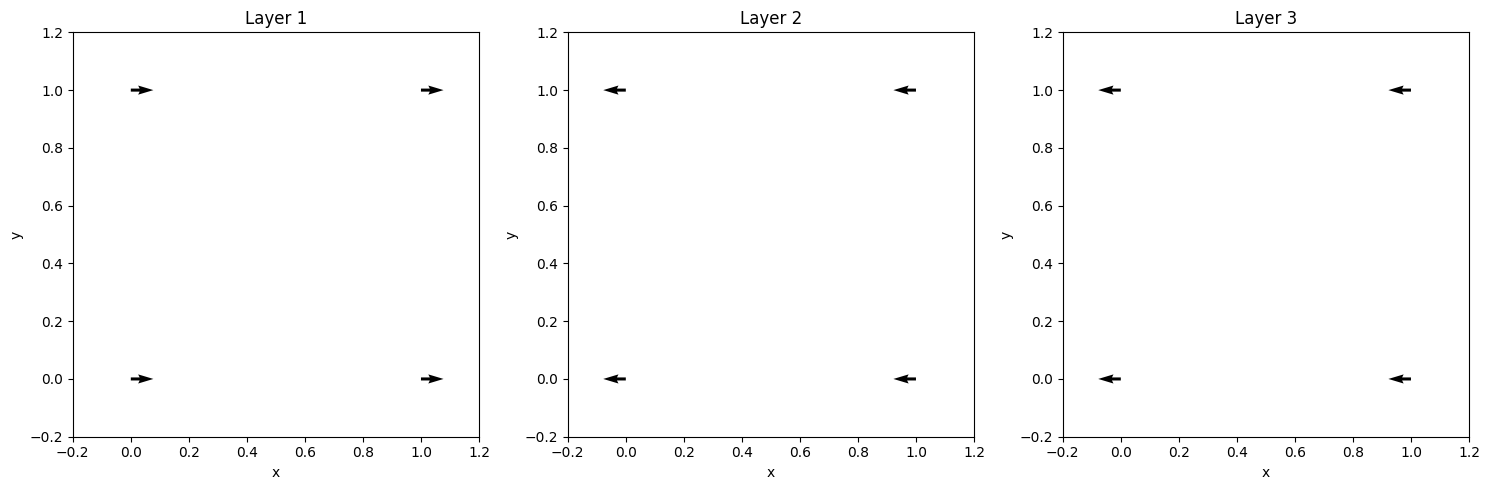

In [ ]:
# Plot wind conditions on each layer
layers = []

for layer in range(env.n_wind_stations[2]):
    layers.append(layer)

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

for layer, ax in zip(layers, axs.ravel()):
    
    ax.quiver(env.xv[:,:,layer].T, env.yv[:,:,layer].T, env.u[:,:,layer], env.v[:,:,layer])
    ax.set_xlim(-0.2,1.2)
    ax.set_ylim(-0.2,1.2)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title(f'Layer {layer+1}')
    
fig.tight_layout()
plt.show()

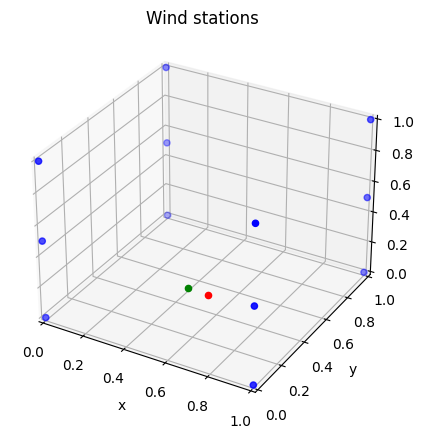

In [ ]:
# Plot wind stations in 3d
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(projection='3d')
ax.scatter(env.xv, env.yv, env.zv, color='blue')
ax.scatter(env.bal_pos[0], env.bal_pos[1], env.bal_pos[2], color='red')
ax.scatter(env.target_pos[0], env.target_pos[1], env.target_pos[2], color='green')
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_zlim(0,1)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

plt.title('Wind stations')
plt.show()

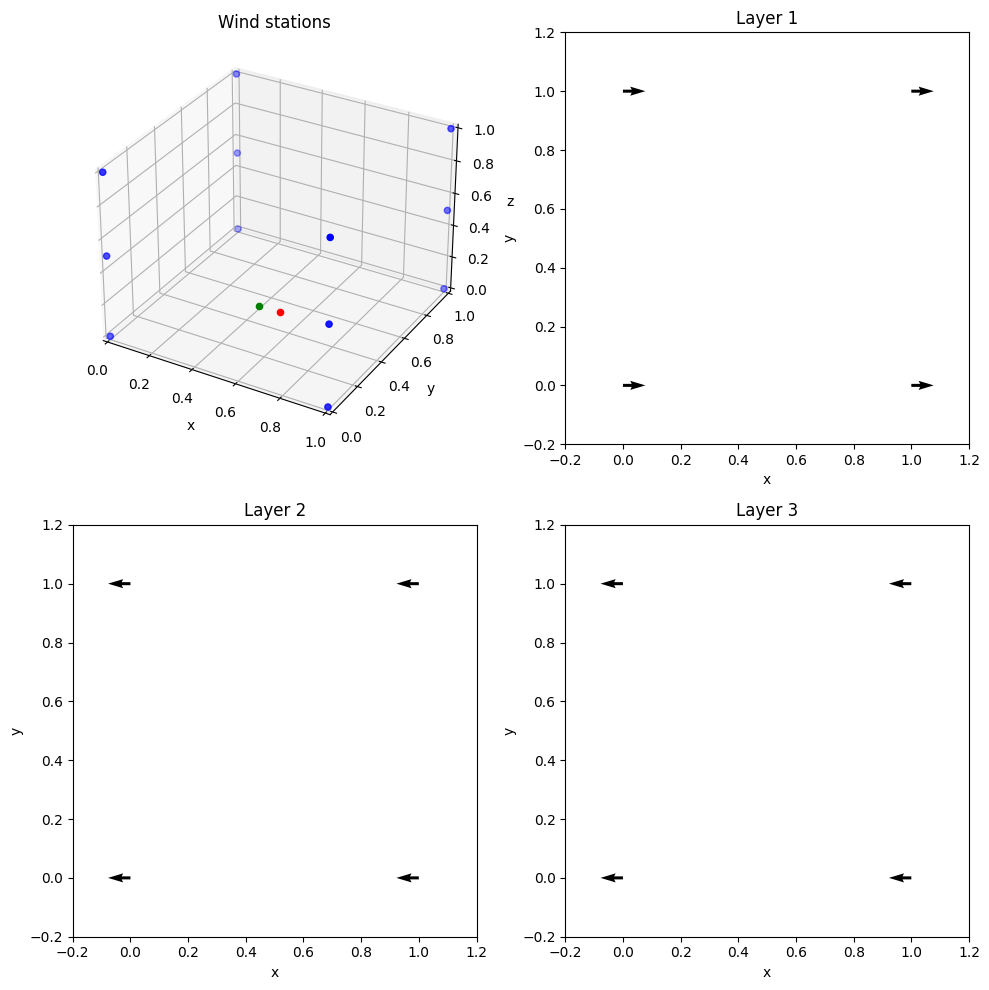

In [ ]:
# Combined plot of 3D wind stations and configuration per layer
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(2, 2, 1, projection='3d')
ax.scatter(env.xv, env.yv, env.zv, color='blue')
ax.scatter(env.bal_pos[0], env.bal_pos[1], env.bal_pos[2], color='red')
ax.scatter(env.target_pos[0], env.target_pos[1], env.target_pos[2], color='green')
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_zlim(0,1)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title(f'Wind stations')

ax = fig.add_subplot(2, 2, 2)
ax.quiver(env.xv[:,:,0].T, env.yv[:,:,0].T, env.u[:,:,0], env.v[:,:,0])
ax.set_xlim(-0.2,1.2)
ax.set_ylim(-0.2,1.2)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title(f'Layer {1}')

ax = fig.add_subplot(2, 2, 3)
ax.quiver(env.xv[:,:,1].T, env.yv[:,:,1].T, env.u[:,:,1], env.v[:,:,1])
ax.set_xlim(-0.2,1.2)
ax.set_ylim(-0.2,1.2)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title(f'Layer {2}')

ax = fig.add_subplot(2, 2, 4)
ax.quiver(env.xv[:,:,2].T, env.yv[:,:,2].T, env.u[:,:,2], env.v[:,:,2])
ax.set_xlim(-0.2,1.2)
ax.set_ylim(-0.2,1.2)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title(f'Layer {3}')

fig.tight_layout()
plt.show()

### Proximal Policy Optimization (PPO)

In [ ]:
class Policy(nn.Module):
    
    def __init__(self, num_actions, obs_size):
        
        super().__init__()
        
        self.h1 = nn.Linear(obs_size, 128)
        self.h2 = nn.Linear(128, 64)
        self.h3 = nn.Linear(64, 32)
        self.out = nn.Linear(32, num_actions)
    
    def forward(self, x):

        x = self.h1(x)
        x = F.relu(x)
        x = self.h2(x)
        x = F.relu(x)
        x = self.h3(x)
        x = F.relu(x)
        
        return self.out(x)
        

class Value(nn.Module):
    
    def __init__(self, obs_size):
        
        super().__init__()

        self.h1 = nn.Linear(obs_size, 128)
        self.h2 = nn.Linear(128, 64)
        self.h3 = nn.Linear(64, 32)
        self.out = nn.Linear(32, 1)
    
    def forward(self, x):

        x = self.h1(x)
        x = F.relu(x)
        x = self.h2(x)
        x = F.relu(x)
        x = self.h3(x)
        x = F.relu(x)
        
        return self.out(x)


class PPOAgent:
    
    def __init__(self, discount, lam, lr, clip_eps, num_actions, obs_size):
  
        self.discount = discount
        self.lam = lam
        self.lr = lr
        self.clip_eps = clip_eps
        self.log_probs_old = []
        self.states = []
        self.actions = []
        self.rewards = []
        self.v_preds = []
        self.v_preds_next = []
        self.dones = []

        self.model_policy = Policy(num_actions, obs_size).to(device)
        self.model_policy_old = Policy(num_actions, obs_size).to(device)
        self.model_policy_old.load_state_dict(self.model_policy.state_dict()) # Init Policy Old = Current Policy
        self.model_value = Value(obs_size).to(device)
        self.optimizer_policy = optim.Adam(self.model_policy.parameters(), lr=self.lr)
        self.optimizer_value = optim.Adam(self.model_value.parameters(), lr=self.lr)
        self.criterion = nn.MSELoss()
        self.num_actions = num_actions
    
    def act(self, current_state, test_run):

        if not test_run:    
          self.states.append(current_state)
          self.current_state = torch.from_numpy(np.array(current_state)).float().to(device) # Add batch dimension with unsqueeze(0)... adds first dimension 1
          
          # No gradient tracking for actions
          with torch.no_grad():
              logits = self.model_policy_old(self.current_state) # Get logits from policy network
          
          dist = Categorical(logits=logits) # Create distribution and sample from distribution
          self.action = dist.sample() # Select action from distribution
          log_prob = dist.log_prob(self.action) # Get log probability of the action the agent took
          self.log_probs_old.append(log_prob) # Store log probability of action for training
          self.action = int(self.action.detach().cpu().data.numpy())
          
          v_pred = self.model_value(self.current_state) # Get value of state from value network
          self.v_preds.append(v_pred[0]) # Store v_pred for training
          
          self.actions.append(self.action)
        
        else:
          self.current_state = torch.from_numpy(np.array(current_state)).float().to(device) # Add batch dimension with unsqueeze(0)... adds first dimension 1
          
          # No gradient tracking for actions
          with torch.no_grad():
              logits = self.model_policy_old(self.current_state) # Get logits from policy network
          
          dist = Categorical(logits=logits) # Create distribution and sample from distribution
          self.action = dist.sample() # Select action from distribution
          log_prob = dist.log_prob(self.action) # Get log probability of the action the agent took
          self.action = int(self.action.detach().cpu().data.numpy())     
        
        return self.action
    
    def train(self, n_epochs, minibatch_size):
        
        # Update old network with new network
        self.model_policy_old.load_state_dict(self.model_policy.state_dict()) # Init Policy Old = Current Policy
        
        # Add last v_preds_next to v_preds for gae calculation
        self.v_preds_all = self.v_preds.copy()
        self.v_preds_all.append(self.v_preds_next[-1])
        self.v_preds_all = torch.stack(self.v_preds_all).detach() # GAE Calculation doesn't track gradients
        
        # --------
        # Calc GAE
        # --------
        rewards = torch.from_numpy(np.array(self.rewards))
        T = len(rewards)

        gae = np.empty(T, dtype=np.float32)
        future_gae = 0.0 
        not_dones = 1 - np.array(self.dones)
        
        for t in reversed(range(T)):
            delta = rewards[t] + self.discount * self.v_preds_all[t+1] * not_dones[t] - self.v_preds_all[t]
            future_gae = delta + self.discount * self.lam * not_dones[t] * future_gae
            gae[t] = future_gae
            
        self.advs_target = torch.tensor(gae)
        self.advs_policy = gae
        
        #-------------------
        # Calc Value Targets
        #-------------------
        self.v_preds_target = self.v_preds.copy()
        self.v_preds_target = torch.stack(self.v_preds_target).detach() # No gradient for V targets
        self.v_targets = self.advs_target.to(device) + self.v_preds_target.to(device)
        
        # Train for n epochs
        for epoch in range(n_epochs):
        
            # Iterate over n minibatches
            n_minibatches = int(T / minibatch_size)
            
            for minibatch in range(n_minibatches):
        
                # Sample minibatch indices
                minibatch_idx = np.random.choice(T, n_minibatches, replace=False)
                states_batch = np.array(self.states)[minibatch_idx]
                actions_batch = torch.from_numpy(np.array(self.actions))[minibatch_idx]
                log_probs_old_batch = torch.stack(self.log_probs_old)[minibatch_idx].to(device)
                advs_policy_batch = torch.tensor(self.advs_policy)[minibatch_idx]
                v_preds_batch = []
                v_targets_batch = self.v_targets[minibatch_idx]
                
                # Calc v_preds per minibatch, since we track gradients per minibatch
                for t in range(len(states_batch)):
                    state = torch.from_numpy(states_batch[t]).float().to(device)
                    v_pred = self.model_value(state) # Get value of state from value network
                    v_preds_batch.append(v_pred[0]) # Store v_pred for training
                    
                v_preds_batch = torch.stack(v_preds_batch).to(device)
         
                # -----------------
                # Calc Policy ratio
                # -----------------
                # Calc log probs for minibatch with current model for each action in trajectory, to compare with log probs from old model
                log_probs_batch = []
                
                for t in range(len(states_batch)):
                    state = torch.from_numpy(states_batch[t]).float().to(device)
                    logits = self.model_policy(state) # Get logits from policy network
                    dist = Categorical(logits=logits) # Create distribution and sample from distribution
                    log_prob = dist.log_prob(actions_batch[t].to(device)) # Get log probability of the action the agent took
                    log_probs_batch.append(log_prob) # Store current log probability of action for training

                # Ratios
                log_probs_batch = torch.stack(log_probs_batch).to(device)
                ratios = torch.exp(log_probs_batch - log_probs_old_batch)

                # non clipped and clipped loss
                sur_1 = ratios.to(device) * advs_policy_batch.to(device)
                sur_2 = torch.clamp(ratios.to(device), 1.0 - self.clip_eps, 1.0 + self.clip_eps) * advs_policy_batch.to(device)
                clip_loss = -torch.min(sur_1.to(device), sur_2.to(device)).mean()
                loss_policy = clip_loss
 
                # -------------
                # Update Policy
                # -------------
                self.optimizer_policy.zero_grad()
                loss_policy.backward()
                nn.utils.clip_grad_value_(self.model_policy.parameters(), clip_value=0.5)
                self.optimizer_policy.step()

                # ------------
                # Update Value
                # ------------
                self.optimizer_value.zero_grad()
                loss_value = self.criterion(v_preds_batch, v_targets_batch) # Calc Value loss with MSE
                loss_value.backward()
                nn.utils.clip_grad_value_(self.model_value.parameters(), clip_value=0.5)
                self.optimizer_value.step()
                
        # Reset trajectory after training, since we are on-policy
        self.states = []
        self.actions = []
        self.rewards = []
        self.log_probs = []
        self.log_probs_old = []
        self.v_preds = []
        self.v_preds_next = []
        self.dones = []

    def save_policy_model(self, path):
        torch.save(self.model_policy_old, path)

    def load_policy_model(self, path):
        self.model_policy_old = torch.load(path)

### Training parameters for all experiments

In [ ]:
# PPO config
discount = 0.99
lam = 0.9
lr = 0.00025
clip_eps = 0.1
n_iterations = 100
n_timesteps = 1000
n_epochs = 10
minibatch_size = 32

# Experiment params
reward_thresh = 0.75
n_teststeps = 5000

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


### Fixed Curriculum

#### Generate Fixed Curriculums
A curriculum contains 10 different vertical speeds sorted by descending order (i.e. higher vertical speeds is easier).   

Three different fixed curriculums with 10 tasks each is created with different task schedules.

In [ ]:
T = 10
init_speed = 0.25
final_speed = 0.025
current_speed = init_speed
delta_linear = (init_speed - final_speed) / (T-1)

# Fast decline
curriculum_fast = []
deltas = []

for t in range(1, T+1):
  new_speed = init_speed / t
  delta = current_speed - new_speed
  current_speed = new_speed
  curriculum_fast.append(new_speed)
  deltas.append(delta)

deltas.reverse()

# Slow decline
curriculum_slow = []
curriculum_slow.append(init_speed)
current_speed = init_speed

for t in range(1, T):
  current_speed = current_speed - deltas[t-1]
  curriculum_slow.append(current_speed)

# Linear decline
curriculum_linear = []
curriculum_linear.append(init_speed)

for t in range(1, T):
  curriculum_linear.append(init_speed - t * delta_linear)

curriculums_df = pd.DataFrame({'linear': curriculum_linear, 'fast': curriculum_fast, 'slow': curriculum_slow})
curriculums_df

,linear,fast,slow
0,0.250,0.250000,0.250000
1,0.225,0.125000,0.247222
2,0.200,0.083333,0.243750
3,0.175,0.062500,0.239286
4,0.150,0.050000,0.233333
5,0.125,0.041667,0.225000
6,0.100,0.035714,0.212500
7,0.075,0.031250,0.191667
8,0.050,0.027778,0.150000
9,0.025,0.025000,0.025000


In [ ]:
# Generate fixed curriculum configs
experiments = ['linear', 'fast', 'slow']

for experiment in experiments:

  vert_speeds = curriculums_df[experiment].values

  curriculum = []

  # Default for all tasks
  max_steps = 200
  n_wind_stations = [2, 2, 3]
  std_wind_speed = 0.01
  target_pos = [0.4, 0.5, 0]
  bal_pos = [0.5, 0.5, 0]
  init_vert_speed = 0.25
  min_pos_diff = 0.03

  for idx, vert_speed in enumerate(vert_speeds):
    task = idx + 1

    config = {'task': task,
              'max_steps': max_steps,
              'n_wind_stations': n_wind_stations,
              'std_wind_speed': std_wind_speed,
              'bal_pos': np.array(bal_pos),
              'target_pos': np.array(target_pos),
              'wind_direction': np.array([[[0, 180, 180],[0, 180, 180]],[[0, 180, 180],[0, 180, 180]]]), # Optional, if not provided, standard is used, # Optional, if not provided, standard is used
              'wind_speed': np.array([[[0.01, 0.05, 0.05],[0.01, 0.05, 0.05]],[[0.01, 0.05, 0.05],[0.01, 0.05, 0.05]]]), # Optional, if not provided, standard is used
              'vert_speed': vert_speed,
              'min_pos_diff': min_pos_diff}

    curriculum.append(config)

  # Save curriculum
  curriculum_df = pd.DataFrame(curriculum)
  curriculum_df.to_pickle(os.path.join(root_dir_model, experiment, 'curriculum_df.pkl'))

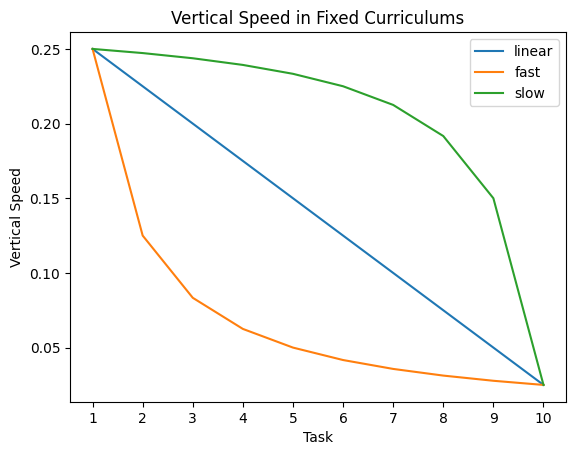

In [ ]:
# Plot Curriculum
experiments = ['linear', 'fast', 'slow']

for experiment in experiments:
  curriculum_df = pd.read_pickle(os.path.join(root_dir_model, experiment, 'curriculum_df.pkl'))
  sns.lineplot(curriculum_df, x='task', y='vert_speed', label=experiment)

plt.xticks([i for i in range(1,11)])
plt.xlabel('Task')
plt.ylabel('Vertical Speed')
plt.title('Vertical Speed in Fixed Curriculums')
plt.show()

#### Train on fixed curriculums
Experiments include:
- Fast
- Slow
- Linear
- Two Steps (first and final task)
- From Scratch (only final task)

In [ ]:
# Load curriculum
experiment = 'fast'

if experiment=='twosteps':
  curriculum_df = pd.read_pickle(os.path.join(root_dir_model, 'linear', 'curriculum_df.pkl'))
  curriculum = curriculum_df.to_dict('records')
  curriculum = [curriculum[0], curriculum[-1]] # Get first and last configuration
elif experiment=='fromscratch':
  curriculum_df = pd.read_pickle(os.path.join(root_dir_model, 'linear', 'curriculum_df.pkl'))
  curriculum = curriculum_df.to_dict('records')
  curriculum = [curriculum[-1]] # Get final configuration
else:
  curriculum_df = pd.read_pickle(os.path.join(root_dir_model, experiment, 'curriculum_df.pkl'))
  curriculum = curriculum_df.to_dict('records')

curriculum

[{'task': 1,
  'max_steps': 200,
  'n_wind_stations': [2, 2, 3],
  'std_wind_speed': 0.01,
  'bal_pos': array([0.5, 0.5, 0. ]),
  'target_pos': array([0.4, 0.5, 0. ]),
  'wind_direction': array([[[  0, 180, 180],
          [  0, 180, 180]],
  
         [[  0, 180, 180],
          [  0, 180, 180]]]),
  'wind_speed': array([[[0.01, 0.05, 0.05],
          [0.01, 0.05, 0.05]],
  
         [[0.01, 0.05, 0.05],
          [0.01, 0.05, 0.05]]]),
  'vert_speed': 0.25,
  'min_pos_diff': 0.03},
 {'task': 2,
  'max_steps': 200,
  'n_wind_stations': [2, 2, 3],
  'std_wind_speed': 0.01,
  'bal_pos': array([0.5, 0.5, 0. ]),
  'target_pos': array([0.4, 0.5, 0. ]),
  'wind_direction': array([[[  0, 180, 180],
          [  0, 180, 180]],
  
         [[  0, 180, 180],
          [  0, 180, 180]]]),
  'wind_speed': array([[[0.01, 0.05, 0.05],
          [0.01, 0.05, 0.05]],
  
         [[0.01, 0.05, 0.05],
          [0.01, 0.05, 0.05]]]),
  'vert_speed': 0.125,
  'min_pos_diff': 0.03},
 {'task': 3,
  'max_s

In [ ]:
# Run training with fixed curriculum
start = dt.datetime.now().replace(microsecond=0)
trial = 4

agent = PPOAgent(discount, lam, lr, clip_eps, num_actions, obs_size)

# Stats
train_stats = []
test_stats_all = []
episode = 0
episode_steps = 0
total_steps = 0

for config in curriculum:

  solved = False
  best_reward = 0

  task = config['task']
  target_pos = config['target_pos']
  current_bal_pos = config['bal_pos']

  print('Start task: ', task)

  env = CoBaEn(render_mode='rgb_array', config=config)
  #env = RecordVideo(env, os.path.join(root_dir_video, experiment, 'train', str(trial), str(task)))
  env = FlattenObservation(env)
  state, info = env.reset()

  episode_reward = 0

  for iteration in range(n_iterations):
      
      for timestep in range(n_timesteps):

          total_steps += 1
          episode_steps += 1

          action = agent.act(state, False)
          next_state, reward, terminated, truncated, info = env.step(action)
          agent.rewards.append(reward)

          state = next_state.copy()

          # Vpred of next state
          next_state = torch.from_numpy(np.array(next_state)).float().to(device)
          v_pred_next = agent.model_value(next_state)
          agent.v_preds_next.append(v_pred_next[0])
          agent.dones.append(terminated)

          episode_reward += reward

          if terminated or truncated:

              pos_diff = info['pos_diff']
              #print(f'Task: {task}, Target_Pos: {target_pos}, Bal_Pos: {current_bal_pos}, Iteration: {iteration}, Episode: {episode}, Reward: {episode_reward}, Position Diff: {pos_diff}, Episode Steps: {episode_steps}, Total Steps: {total_steps}')

              train_stats.append({
                'Trial': trial,
                'Task': task,
                'Iteration': iteration,
                'Episode': episode,
                'Episode Reward': episode_reward,
                'Position Diff': pos_diff,
                'Episode Steps': episode_steps,
                'Total Steps': total_steps
              })

              episode_reward = 0
              episode += 1
              episode_steps = 0

              state, info = env.reset()
          
      # After collecting a trajectory of n_timesteps, start training for n_epochs and minibatch_size
      agent.train(n_epochs, minibatch_size)

      # Perform test runs
      test_stats = []
      total_test_steps = 0
      test_episode_steps = 0
      test_episode = 0

      test_env = CoBaEn(render_mode='rgb_array', config=config)
      test_env = FlattenObservation(test_env)
      test_state, test_info = test_env.reset()

      test_episode_reward = 0

      for i in range(n_teststeps):
        
        total_test_steps += 1
        test_episode_steps += 1
        
        test_action = agent.act(test_state, True) # Test run on same agent, but without accumulating training data
        next_test_state, test_reward, test_terminated, test_truncated, test_info = test_env.step(test_action)
        
        test_state = next_test_state
        test_episode_reward += test_reward

        if test_terminated or test_truncated:

            pos_diff = test_info['pos_diff']
            #print(f'TEST: Task: {task}, Target_Pos: {target_pos}, Bal_Pos: {current_bal_pos}, Iteration: {iteration}, Episode: {test_episode}, Reward: {test_episode_reward}, Position Diff: {pos_diff}, Episode Steps: {test_episode_steps}, Total Steps: {total_test_steps}')

            test_stats.append({
              'Trial': trial,
              'Task': task,
              'Iteration': iteration,
              'Episode': test_episode,
              'Episode Steps': test_episode_steps,
              'Total Steps': total_test_steps,
              'Episode Reward': test_episode_reward
            })

            test_stats_all.append({
              'Trial': trial,
              'Task': task,
              'Iteration': iteration,
              'Episode': test_episode,
              'Episode Steps': test_episode_steps,
              'Total Steps': total_test_steps,
              'Episode Reward': test_episode_reward
            })

            test_episode_reward = 0
            test_episode += 1
            test_episode_steps = 0
      
            test_state, test_info = test_env.reset()

      temp_df = pd.DataFrame(test_stats)
      latest_reward_avg = temp_df['Episode Reward'].mean()
      #print(f'Iteration: {iteration}, Test Reward Avg: {latest_reward_avg}')
          
      test_env.close()

      # Save best only
      if latest_reward_avg > best_reward:
        best_reward = latest_reward_avg
        agent.save_policy_model(os.path.join(root_dir_model, experiment, str(trial), str(task))) # Save model for testing!!!

      # If moving average above threshold increase difficulty, else continue training until max iterations reached
      if latest_reward_avg >= reward_thresh:
        solved = True
        break

  print(f'Task: {task}, Best Reward: {best_reward}, Solved: {solved}')

  env.close()

# Save stats
train_stats_df = pd.DataFrame(train_stats)
train_stats_df.to_pickle(os.path.join(root_dir_model, experiment, str(trial), 'train_stats_df.pkl'))

test_stats_all_df = pd.DataFrame(test_stats_all)
test_stats_all_df.to_pickle(os.path.join(root_dir_model, experiment, str(trial), 'test_stats_all_df.pkl'))

end = dt.datetime.now().replace(microsecond=0)
print('Time running:', end-start)

Start task:  1
Task: 1, Best Reward: 0.8104089219330854, Solved: True
Start task:  2
Task: 2, Best Reward: 0.7614678899082569, Solved: True
Start task:  3
Task: 3, Best Reward: 0.8235294117647058, Solved: True
Start task:  4
Task: 4, Best Reward: 0.7763157894736842, Solved: True
Start task:  5
Task: 5, Best Reward: 0.7531645569620253, Solved: True
Start task:  6
Task: 6, Best Reward: 0.8449612403100775, Solved: True
Start task:  7
Task: 7, Best Reward: 0.8181818181818182, Solved: True
Start task:  8
Task: 8, Best Reward: 0.8037974683544303, Solved: True
Start task:  9
Task: 9, Best Reward: 0.7611940298507462, Solved: True
Start task:  10
Task: 10, Best Reward: 0.8333333333333334, Solved: True
Time running: 1:21:46


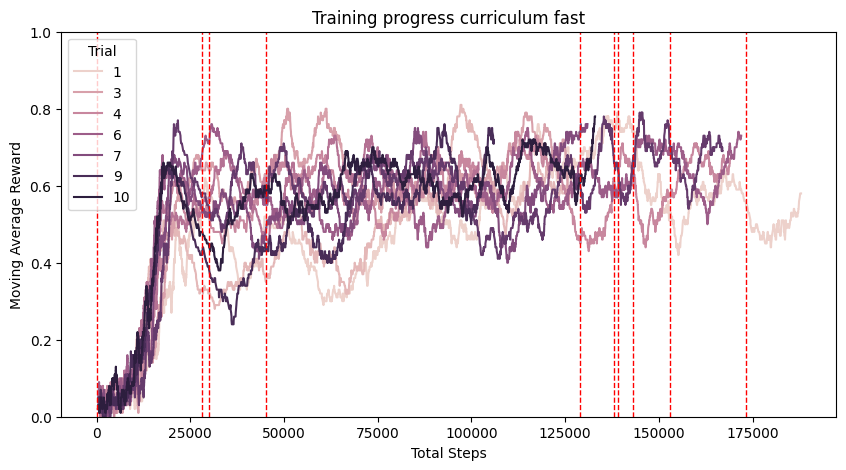

In [ ]:
# Moving average across all tasks and episodes
experiment = 'fast'

n_moving = 100

plt.figure(figsize=(10,5))

all_stats_df = pd.DataFrame()

trials = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

for trial in trials:

  stats_df = pd.read_pickle(os.path.join(root_dir_model, experiment, str(trial), 'train_stats_df.pkl'))
  stats_df['Moving Average Reward'] = stats_df['Episode Reward'].rolling(n_moving).mean()

  all_stats_df = pd.concat([all_stats_df, stats_df])

all_stats_df.reset_index(inplace=True)

g = sns.lineplot(data=all_stats_df, x='Total Steps', y='Moving Average Reward', hue='Trial')
g.set_ylim(0, 1)

stats_df = pd.read_pickle(os.path.join(root_dir_model, experiment, str(1), 'train_stats_df.pkl'))
ymin, ymax = g.get_ylim()
g.vlines(stats_df.groupby('Task').min()['Total Steps'].values, ymin=ymin, ymax=ymax, colors=['red'], ls='dashed', lw=1)

plt.title(f'Training progress curriculum {experiment}')
plt.show()

#### Test all agent/task combinations incl. random agent

In [ ]:
experiment = 'fast' # Load configs

if experiment=='twosteps':
  curriculum_df = pd.read_pickle(os.path.join(root_dir_model, 'linear', 'curriculum_df.pkl'))
  curriculum_sub_df = curriculum_df[(curriculum_df['task']==1) | (curriculum_df['task']==10)]
  curriculum_sub = curriculum_sub_df.to_dict('records')
  agent_versions = [0] + [task['task'] for task in curriculum_sub] # 0 = random agent
else:
  curriculum_df = pd.read_pickle(os.path.join(root_dir_model, experiment, 'curriculum_df.pkl'))
  curriculum_sub_df = curriculum_df[(curriculum_df['task']==1) | (curriculum_df['task']==3) | (curriculum_df['task']==6) | (curriculum_df['task']==8) | (curriculum_df['task']==10)]
  curriculum_sub = curriculum_sub_df.to_dict('records')
  agent_versions = [0] + [task['task'] for task in curriculum_sub] # 0 = random agent

agent_versions

[0, 1, 3, 6, 8, 10]

In [ ]:
# Test runs on all tasks in curriculum with all agents trained after each task, incl. random agent for all tasks
start = dt.datetime.now().replace(microsecond=0)

all_test_stats = []
trial_models = 4

for config in curriculum_sub:

  task = config['task']

  for agent_version in agent_versions:

    agent = PPOAgent(discount, lam, lr, clip_eps, num_actions, obs_size)

    if agent_version > 0: # Load model for non-random agents
      agent.load_policy_model(os.path.join(root_dir_model, experiment, str(trial_models), str(agent_version)))

    env = CoBaEn(render_mode='rgb_array', config=config)
    #env = RecordVideo(env, os.path.join(root_dir_video, experiment, 'test', str(trial_models), str(config['task']), str(agent_version)))
    env = FlattenObservation(env)
    state, info = env.reset()

    episode = 0
    total_steps = 0
    episode_steps = 0
    episode_reward = 0

    for i in range(n_teststeps):

        total_steps += 1
        episode_steps += 1
        
        if agent_version > 0:
          action = agent.act(state, True) # Non random action
        else:
          action = env.action_space.sample() # Random action 
        
        next_state, reward, terminated, truncated, info = env.step(action)
        
        state = next_state
        episode_reward += reward

        if terminated or truncated:
            #print(f'Trial: {trial}, Task: {task}, Agent Version: {agent_version}, Episode: {episode}, Reward: {episode_reward}, Episode Steps: {episode_steps}, Steps Total: {total_steps}')

            all_test_stats.append({
              'Task': task,
              'Agent Version': agent_version,
              'Episode': episode,
              'Episode Steps': episode_steps,
              'Total Steps': total_steps,
              'Episode Reward': episode_reward
            })
                
            episode_reward = 0
            episode += 1
            episode_steps = 0
            
            state, info = env.reset()

    env.close()
      
# Save stats
all_test_stats_df = pd.DataFrame(all_test_stats)
all_test_stats_df.to_pickle(os.path.join(root_dir_model, experiment, str(trial_models), 'combined_test_stats_df.pkl'))

end = dt.datetime.now().replace(microsecond=0)
print('Time running:', end-start)

Time running: 0:02:50


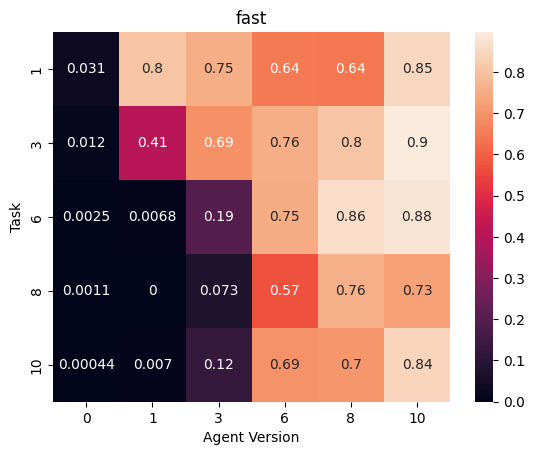

In [ ]:
# Average over all trials
experiment = 'fast'
trial_models = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

all_test_stats_df = pd.DataFrame()

for trial_model in trial_models:
  temp_df = pd.read_pickle(os.path.join(root_dir_model, experiment, str(trial_model), 'combined_test_stats_df.pkl'))
  all_test_stats_df = pd.concat([all_test_stats_df, temp_df])

test_pivot_df = all_test_stats_df[['Task', 'Agent Version', 'Episode Reward']].groupby(by=['Task', 'Agent Version']).mean().pivot_table(index='Task', columns='Agent Version', aggfunc='mean').droplevel(0, axis=1)
sns.heatmap(test_pivot_df, annot=True)
plt.title(experiment)
plt.show()

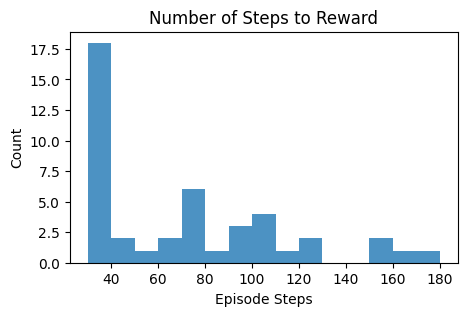

In [ ]:
# Histogram Number of steps for final agent with reward = 1
plt.figure(figsize=(5,3))
mask = (all_test_stats_df['Task']==10) & (all_test_stats_df['Agent Version']==10) & (all_test_stats_df['Episode Reward']==1)
sns.histplot(all_test_stats_df[mask], x='Episode Steps', binwidth=10, alpha=0.8, linewidth=0)
plt.title('Number of Steps to Reward')
plt.show()

### Adaptive Curriculum

#### General functions

In [ ]:
# Function to train adaptive curriculum agent
def train_agent(agent, experiment, trial, task, state_config):

  # Stats
  train_stats = []
  test_stats_all = []
  episode = 0
  episode_steps = 0
  total_steps = 0

  solved = False
  best_reward = 0

  env = CoBaEn(render_mode='rgb_array', config=state_config)
  env = FlattenObservation(env) # Flattens dict of observation space
  state, info = env.reset()

  episode_reward = 0

  for iteration in range(n_iterations):
      
      for timestep in range(n_timesteps):

          total_steps += 1
          episode_steps += 1

          action = agent.act(state, False)
          next_state, reward, terminated, truncated, info = env.step(action)
          agent.rewards.append(reward)

          state = next_state.copy()

          # Vpred of next state
          next_state = torch.from_numpy(np.array(next_state)).float().to(device)
          v_pred_next = agent.model_value(next_state)
          agent.v_preds_next.append(v_pred_next[0])
          agent.dones.append(terminated)

          episode_reward += reward

          if terminated or truncated:

              # Calc Diff
              pos_diff = info['pos_diff']
              #print(f'Sample Iteration: {sample_iteration}, Target_Pos: {target_pos}, Bal_Pos: {current_bal_pos}, Iteration: {iteration}, Episode: {episode}, Reward: {episode_reward}, Position Diff: {pos_diff}, Episode Steps: {episode_steps}, Total Steps: {total_steps}')

              train_stats.append({
                'Trial': trial,
                'Sample Iteration': task,
                'Iteration': iteration,
                'Episode': episode,
                'Episode Reward': episode_reward,
                'Position Diff': pos_diff,
                'Episode Steps': episode_steps,
                'Total Steps': total_steps
              })

              episode_reward = 0
              episode += 1
              episode_steps = 0

              state, info = env.reset()
          
      # After collecting a trajectory of n_timesteps, start training for n_epochs and minibatch_size
      agent.train(n_epochs, minibatch_size)

      # Perform n test runs
      test_stats = []
      total_test_steps = 0
      test_episode_steps = 0
      test_episode = 0

      test_env = CoBaEn(render_mode='rgb_array', config=state_config)
      test_env = FlattenObservation(test_env) # Flattens dict of observation space
      test_state, test_info = test_env.reset()

      test_episode_reward = 0

      for i in range(n_teststeps):
        
        total_test_steps += 1
        test_episode_steps += 1
        
        test_action = agent.act(test_state, True) # Test run on same agent, but without accumulating training data
        next_test_state, test_reward, test_terminated, test_truncated, test_info = test_env.step(test_action)
        
        test_state = next_test_state
        test_episode_reward += test_reward

        if test_terminated or test_truncated:

            # Calc Diff
            pos_diff = test_info['pos_diff']
            #print(f'TEST: Task: {task}, Target_Pos: {target_pos}, Bal_Pos: {current_bal_pos}, Iteration: {iteration}, Episode: {test_episode}, Reward: {test_episode_reward}, Position Diff: {pos_diff}, Episode Steps: {test_episode_steps}, Total Steps: {total_test_steps}')

            test_stats.append({
              'Trial': trial,
              'Sample Iteration': task,
              'Iteration': iteration,
              'Episode': test_episode,
              'Episode Steps': test_episode_steps,
              'Total Steps': total_test_steps,
              'Episode Reward': test_episode_reward
            })

            test_stats_all.append({
              'Trial': trial,
              'Sample Iteration': task,
              'Iteration': iteration,
              'Episode': test_episode,
              'Episode Steps': test_episode_steps,
              'Total Steps': total_test_steps,
              'Episode Reward': test_episode_reward
            })

            test_episode_reward = 0
            test_episode = test_episode + 1
            test_episode_steps = 0
      
            test_state, test_info = test_env.reset()

      temp_df = pd.DataFrame(test_stats)
      latest_reward_avg = temp_df['Episode Reward'].mean()
      #print(f'Iteration: {iteration}, Test Reward Avg: {latest_reward_avg}')
          
      test_env.close()

      # Save best only
      if latest_reward_avg > best_reward:
        best_reward = latest_reward_avg
        agent.save_policy_model(os.path.join(root_dir_model, experiment, str(trial), str(task))) # Save model for testing!!!

      # If moving average above threshold increase difficulty, else continue training until max iterations reached
      if latest_reward_avg >= reward_thresh:
        solved = True
        break

  env.close()

  # Save stats
  train_stats_df = pd.DataFrame(train_stats)
  train_stats_df.to_pickle(os.path.join(root_dir_model, experiment, str(trial), f'train_stats_df_{task}.pkl'))

  test_stats_all_df = pd.DataFrame(test_stats_all)
  test_stats_all_df.to_pickle(os.path.join(root_dir_model, experiment, str(trial), f'test_stats_all_df_{task}.pkl'))

  return best_reward, solved

In [ ]:
# Function to test adaptive curriculum agent on goal state config
def test_on_goal_state(agent, experiment, trial, task, goal_state_config, file_prefix):

  # Perform n test runs
  test_stats = []
  total_test_steps = 0
  test_episode_steps = 0
  test_episode = 0

  test_env_goal = CoBaEn(render_mode='rgb_array', config=goal_state_config) # Use goal state config

  print('Goal state vert_speed: ', goal_state_config['vert_speed'])

  # Videos of test runs on goal state
  #test_env_goal = RecordVideo(test_env_goal, os.path.join(root_dir_video, experiment, 'test', str(trial), str(sample_iteration)))
  test_env_goal = FlattenObservation(test_env_goal) # Flattens dict of observation space
  test_state, test_info = test_env_goal.reset()

  test_episode_reward = 0

  for i in range(n_teststeps):
    
    total_test_steps += 1
    test_episode_steps += 1
    
    test_action = agent.act(test_state, True) # Test run on same agent, but without accumulating training data
    next_test_state, test_reward, test_terminated, test_truncated, test_info = test_env_goal.step(test_action)
    
    test_state = next_test_state
    test_episode_reward += test_reward

    if test_terminated or test_truncated:

        test_stats.append({
          'Trial': trial,
          'Sample Iteration': task,
          'Episode': test_episode,
          'Episode Steps': test_episode_steps,
          'Total Steps': total_test_steps,
          'Episode Reward': test_episode_reward
        })

        test_episode_reward = 0
        test_episode += 1
        test_episode_steps = 0

        test_state, test_info = test_env_goal.reset()

  temp_df = pd.DataFrame(test_stats)
  temp_df.to_pickle(os.path.join(root_dir_model, experiment, str(trial), f'{file_prefix}_{task}.pkl'))

  latest_goal_reward_avg = temp_df['Episode Reward'].mean()

  test_env_goal.close()

  return latest_goal_reward_avg

#### Train with sampling promising states
Start training on initial state and continue training by sampling promising new states

In [ ]:
# Load fixed curriculum to extract start and goal state configs
experiment = 'fast' # Load configs from fixed_noreplay experiments
curriculum_df = pd.read_pickle(os.path.join(root_dir_model, experiment, 'curriculum_df.pkl'))
curriculum = curriculum_df.to_dict('records')
start_state_config = curriculum[0]
goal_state_config = curriculum[-1]
new_state_config = start_state_config
vert_speed_start = start_state_config['vert_speed']
vert_speed_goal = goal_state_config['vert_speed']
vert_speed_new = vert_speed_start

print('Init speed: ', vert_speed_new)
print('Final speed: ', vert_speed_goal)

Init speed:  0.25
Final speed:  0.025


In [ ]:
# Run training loop with sampling
start = dt.datetime.now().replace(microsecond=0)

experiment = 'adaptive'
trial = 10

rmin = 0.2 # Min reward during sampling
rmax = 0.5 # Max reward during sampling
n_sample_iterations = 10 # Max number of sampling, upper limit is manually designed fixed curriculum
n_samples = 20 # Number of samples to draw for selection of most promising next state

all_samples_stats = []

# Train agent on initial state
sample_iteration = 1
print('Start Sampling Iteration: ', sample_iteration)

agent = PPOAgent(discount, lam, lr, clip_eps, num_actions, obs_size)
best_reward, solved = train_agent(agent, experiment, trial, sample_iteration, new_state_config)

print(f'Sample Iteration: {sample_iteration}, Best Reward: {best_reward}, Solved: {solved}')

# Test agent on goal state
latest_goal_reward_avg = test_on_goal_state(agent, experiment, trial, sample_iteration, goal_state_config, 'sample_test_on_goal')

all_samples_stats.append({
        'Trial': trial,
        'Sample Iteration': sample_iteration,
        'Vertical Speed': vert_speed_new,
        'Reward Final': latest_goal_reward_avg
      })

print(f'Sample Iteration: {sample_iteration}, Test Reward Avg on final task: {latest_goal_reward_avg}')

if latest_goal_reward_avg >= reward_thresh:
  print(f'Final Task solved')

# Start Sampling
for sample_iteration in range(2, n_sample_iterations+1): # From 2, because we already trained on init state

  # Sample possible new states
  print('Sample min/max: ', vert_speed_goal, vert_speed_new)
  vert_speed_samples = np.random.uniform(vert_speed_goal, vert_speed_new, n_samples)
  sample_test_stats = []

  for vert_speed_sample in vert_speed_samples:

    # If sampled vert speed is within 10 % of goal speed, set goal speed
    if vert_speed_sample <= 1.01 * vert_speed_goal:
      vert_speed_sample = vert_speed_goal

    # Adjust new_state_config
    new_state_config['vert_speed'] = vert_speed_sample

    # Test agent on sample state
    test_stats = []
    total_test_steps = 0
    test_episode_steps = 0
    test_episode = 0

    test_env = CoBaEn(render_mode='rgb_array', config=new_state_config) # Use goal state config
    test_env = FlattenObservation(test_env) # Flattens dict of observation space
    test_state, test_info = test_env.reset()

    test_episode_reward = 0

    for i in range(n_teststeps):
      
      total_test_steps += 1
      test_episode_steps += 1
      
      test_action = agent.act(test_state, True) # Test run on same agent, but without accumulating training data
      next_test_state, test_reward, test_terminated, test_truncated, test_info = test_env.step(test_action)
      
      test_state = next_test_state
      test_episode_reward += test_reward

      if test_terminated or test_truncated:

          # Calc Diff
          pos_diff = test_info['pos_diff']
          #print(f'TEST: Task: {task}, Target_Pos: {target_pos}, Bal_Pos: {current_bal_pos}, Iteration: {iteration}, Episode: {test_episode}, Reward: {test_episode_reward}, Position Diff: {pos_diff}, Episode Steps: {test_episode_steps}, Total Steps: {total_test_steps}')

          test_stats.append({
            'Vert Speed': vert_speed_sample,
            'Episode': test_episode,
            'Episode Reward': test_episode_reward
          })

          test_episode_reward = 0
          test_episode += 1
          test_episode_steps = 0

          test_state, test_info = test_env.reset()

    temp_df = pd.DataFrame(test_stats)
    test_reward_avg = temp_df['Episode Reward'].mean()
    print(f'Vert Speed: {vert_speed_sample}, Test Reward Avg on sampled task: {test_reward_avg}')

    # Add test reward for sample to stats
    sample_test_stats.append({
        'Vert Speed': vert_speed_sample,
        'Test Reward': test_reward_avg
    })
        
    test_env.close()

  # Select most promising state from samples as new state
  # Selection: Top 1 of Records with Test Reward between 0.2 and 0.5 order by Vert Speed ascending
  sample_test_stats_df = pd.DataFrame(sample_test_stats)
  mask = (sample_test_stats_df['Test Reward']>=rmin) & (sample_test_stats_df['Test Reward']<rmax)

  if sample_test_stats_df[mask].size > 0: # Select record with lowest vert speed
    vert_speed_new = sample_test_stats_df[mask].sort_values(by='Vert Speed').iloc[0]['Vert Speed']
  else: # If no sample is within the range, take sample with highest test reward to be on the save side
    vert_speed_new = sample_test_stats_df.sort_values(by='Test Reward', ascending=False).iloc[0]['Vert Speed']
  
  new_state_config['vert_speed'] = vert_speed_new

  # Start training sample
  print(f'Start training sample iteration: {sample_iteration} and vert_speed {vert_speed_new}')

  best_reward, solved = train_agent(agent, experiment, trial, sample_iteration, new_state_config)

  print(f'Test Sample Iteration: {sample_iteration}, Best Reward: {best_reward}, Solved: {solved}')

  # Test agent on goal state
  latest_goal_reward_avg = test_on_goal_state(agent, experiment, trial, sample_iteration, goal_state_config, 'sample_test_on_goal')

  all_samples_stats.append({
          'Trial': trial,
          'R min': rmin,
          'R max': rmax,
          'Sample Iteration': sample_iteration,
          'Vertical Speed': vert_speed_new,
          'Reward Final': latest_goal_reward_avg
        })

  print(f'Sample Iteration: {sample_iteration}, Test Reward Avg on final task: {latest_goal_reward_avg}')

  if latest_goal_reward_avg >= reward_thresh:
    print(f'Final Task solved')
    break
  elif vert_speed_new == vert_speed_goal:
    print(f'Goal vert speed reached, but not solved')
    break

# Save all sample stats
all_samples_stats_df = pd.DataFrame(all_samples_stats)
all_samples_stats_df.to_pickle(os.path.join(root_dir_model, experiment, str(trial), 'all_samples_stats_df.pkl'))

end = dt.datetime.now().replace(microsecond=0)
print('Time running:', end-start)

Start Sampling Iteration:  1
Sample Iteration: 1, Best Reward: 0.8805460750853242, Solved: True
Goal state vert_speed:  0.025
Sample Iteration: 1, Test Reward Avg on final task: 0.0
Sample min/max:  0.025 0.25
Vert Speed: 0.21627795499263866, Test Reward Avg on sampled task: 0.47790055248618785
Vert Speed: 0.07276758751204747, Test Reward Avg on sampled task: 0.0
Vert Speed: 0.10545571866695963, Test Reward Avg on sampled task: 0.40425531914893614
Vert Speed: 0.05095677370596545, Test Reward Avg on sampled task: 0.0
Vert Speed: 0.1347144451156121, Test Reward Avg on sampled task: 0.13023255813953488
Vert Speed: 0.0831914273162604, Test Reward Avg on sampled task: 0.4146341463414634
Vert Speed: 0.07935383416851526, Test Reward Avg on sampled task: 0.0
Vert Speed: 0.195130390866352, Test Reward Avg on sampled task: 0.6018518518518519
Vert Speed: 0.18666261585336053, Test Reward Avg on sampled task: 0.5462184873949579
Vert Speed: 0.12121431034294183, Test Reward Avg on sampled task: 0.79


In [ ]:
# Adaption of vertical speeds and associated final reward
experiment = 'adaptive'
trial = 10
all_samples_stats_df = pd.read_pickle(os.path.join(root_dir_model, experiment, str(trial), f'all_samples_stats_df.pkl'))
all_samples_stats_df

,Trial,Sample Iteration,Vertical Speed,Reward Final,R min,R max
0,10,1,0.250000,0.000000,NaN,NaN
1,10,2,0.073367,0.076923,0.2,0.5
2,10,3,0.036228,0.500000,0.2,0.5
3,10,4,0.025316,0.651163,0.2,0.5
4,10,5,0.025000,0.775862,0.2,0.5


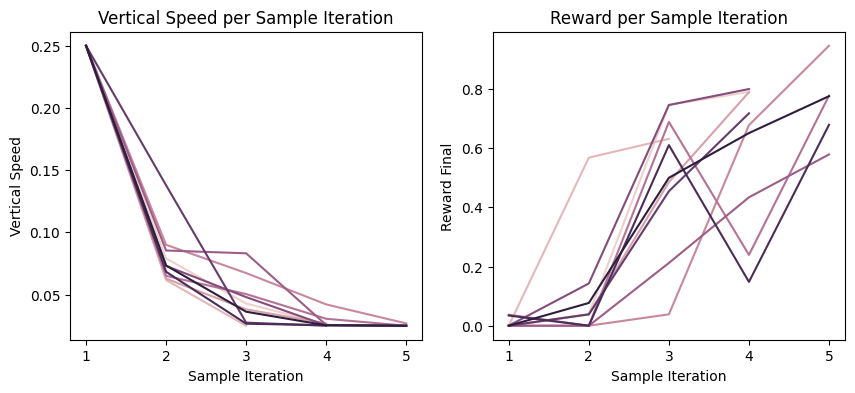

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,4))

experiment = 'adaptive'
trials = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

all_trials_stats_df = pd.DataFrame()

for trial in trials:
  all_samples_stats_df = pd.read_pickle(os.path.join(root_dir_model, experiment, str(trial), f'all_samples_stats_df.pkl'))
  all_trials_stats_df = pd.concat([all_trials_stats_df, all_samples_stats_df])

sns.lineplot(all_trials_stats_df, x='Sample Iteration', y='Vertical Speed', hue='Trial', ax=axs[0])
axs[0].set_title('Vertical Speed per Sample Iteration')
axs[0].get_legend().remove()

all_trials_stats_df = pd.DataFrame()

for trial in trials:
  all_samples_stats_df = pd.read_pickle(os.path.join(root_dir_model, experiment, str(trial), f'all_samples_stats_df.pkl'))
  all_trials_stats_df = pd.concat([all_trials_stats_df, all_samples_stats_df])

sns.lineplot(all_trials_stats_df, x='Sample Iteration', y='Reward Final', hue='Trial', ax=axs[1])
axs[1].set_title('Reward per Sample Iteration')
axs[1].get_legend().remove()
plt.show()

In [ ]:
# Average reward on final task with last sample iteration
experiment = 'adaptive'
trials = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

final_rewards = []

for trial in trials:
  all_samples_stats_df = pd.read_pickle(os.path.join(root_dir_model, experiment, str(trial), f'all_samples_stats_df.pkl'))
  final_reward = all_samples_stats_df.iloc[-1]['Reward Final']
  final_rewards.append(final_reward)

print('Average reward on final task with last iteration: ', np.round(np.mean(final_rewards), 2))

Average reward on final task with last iteration:  0.75


### Additional Figures used in Report

#### Training progress fixed curriculum

Training progress measured as moving average over 100 training episodes (NOT test episodes, since testing is only conducted after each iteration)

Task switches only visible for one trial (red vertical lines)

Plotted against number of steps

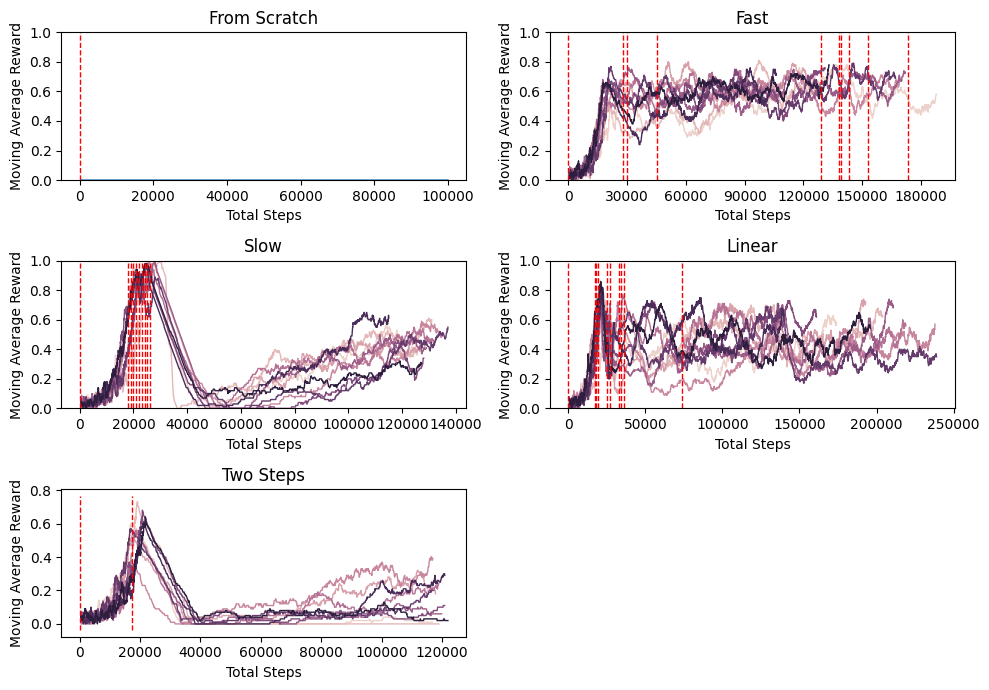

In [ ]:
n_moving = 100
trials = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(10,7))

# From scratch
experiment = 'fromscratch'
row_idx = 0
col_idx = 0

all_stats_df = pd.DataFrame()

for trial in [1]:
  stats_df = pd.read_pickle(os.path.join(root_dir_model, experiment, str(trial), 'stats_df.pkl'))
  stats_df['Moving Average Reward'] = stats_df['Episode Reward'].rolling(n_moving).mean()
  all_stats_df = pd.concat([all_stats_df, stats_df])

all_stats_df.reset_index(inplace=True)
sns.lineplot(data=all_stats_df, x='Total Steps', y='Moving Average Reward', ax=axs[row_idx, col_idx], lw=1)
axs[row_idx, col_idx].set_ylim(0, 1)

stats_df = pd.read_pickle(os.path.join(root_dir_model, experiment, str(1), 'stats_df.pkl'))
ymin, ymax = axs[row_idx, col_idx].get_ylim()
axs[row_idx, col_idx].vlines(stats_df.groupby('Task').min()['Total Steps'].values, ymin=ymin, ymax=ymax, colors=['red'], ls='dashed', lw=1)
axs[row_idx, col_idx].set_title('From Scratch')

# Fast
experiment = 'fast'
row_idx = 0
col_idx = 1

all_stats_df = pd.DataFrame()

for trial in trials:
  stats_df = pd.read_pickle(os.path.join(root_dir_model, experiment, str(trial), 'train_stats_df.pkl'))
  stats_df['Moving Average Reward'] = stats_df['Episode Reward'].rolling(n_moving).mean()
  all_stats_df = pd.concat([all_stats_df, stats_df])

all_stats_df.reset_index(inplace=True)
sns.lineplot(data=all_stats_df, x='Total Steps', y='Moving Average Reward', hue='Trial', ax=axs[row_idx, col_idx], lw=1)
axs[row_idx, col_idx].set_ylim(0, 1)
axs[row_idx, col_idx].set_xticks([0, 30000, 60000, 90000, 120000, 150000, 180000])

stats_df = pd.read_pickle(os.path.join(root_dir_model, experiment, str(1), 'train_stats_df.pkl'))
ymin, ymax = axs[row_idx, col_idx].get_ylim()
axs[row_idx, col_idx].vlines(stats_df.groupby('Task').min()['Total Steps'].values, ymin=ymin, ymax=ymax, colors=['red'], ls='dashed', lw=1)
axs[row_idx, col_idx].set_title('Fast')
axs[row_idx, col_idx].get_legend().remove()

# Slow
experiment = 'slow'
row_idx = 1
col_idx = 0

all_stats_df = pd.DataFrame()

for trial in trials:
  stats_df = pd.read_pickle(os.path.join(root_dir_model, experiment, str(trial), 'train_stats_df.pkl'))
  stats_df['Moving Average Reward'] = stats_df['Episode Reward'].rolling(n_moving).mean()
  all_stats_df = pd.concat([all_stats_df, stats_df])

all_stats_df.reset_index(inplace=True)
sns.lineplot(data=all_stats_df, x='Total Steps', y='Moving Average Reward', hue='Trial', ax=axs[row_idx, col_idx], lw=1)
axs[row_idx, col_idx].set_ylim(0, 1)

stats_df = pd.read_pickle(os.path.join(root_dir_model, experiment, str(1), 'train_stats_df.pkl'))
ymin, ymax = axs[row_idx, col_idx].get_ylim()
axs[row_idx, col_idx].vlines(stats_df.groupby('Task').min()['Total Steps'].values, ymin=ymin, ymax=ymax, colors=['red'], ls='dashed', lw=1)
axs[row_idx, col_idx].set_title('Slow')
axs[row_idx, col_idx].get_legend().remove()

# Linear
experiment = 'linear'
row_idx = 1
col_idx = 1

all_stats_df = pd.DataFrame()

for trial in trials:
  stats_df = pd.read_pickle(os.path.join(root_dir_model, experiment, str(trial), 'train_stats_df.pkl'))
  stats_df['Moving Average Reward'] = stats_df['Episode Reward'].rolling(n_moving).mean()
  all_stats_df = pd.concat([all_stats_df, stats_df])

all_stats_df.reset_index(inplace=True)
sns.lineplot(data=all_stats_df, x='Total Steps', y='Moving Average Reward', hue='Trial', ax=axs[row_idx, col_idx], lw=1)
axs[row_idx, col_idx].set_ylim(0, 1)

stats_df = pd.read_pickle(os.path.join(root_dir_model, experiment, str(1), 'train_stats_df.pkl'))
ymin, ymax = axs[row_idx, col_idx].get_ylim()
axs[row_idx, col_idx].vlines(stats_df.groupby('Task').min()['Total Steps'].values, ymin=ymin, ymax=ymax, colors=['red'], ls='dashed', lw=1)
axs[row_idx, col_idx].set_title('Linear')
axs[row_idx, col_idx].get_legend().remove()

# Two steps
experiment = 'twosteps'
row_idx = 2
col_idx = 0

all_stats_df = pd.DataFrame()

for trial in trials:
  stats_df = pd.read_pickle(os.path.join(root_dir_model, experiment, str(trial), 'train_stats_df.pkl'))
  stats_df['Moving Average Reward'] = stats_df['Episode Reward'].rolling(n_moving).mean()
  all_stats_df = pd.concat([all_stats_df, stats_df])

all_stats_df.reset_index(inplace=True)
sns.lineplot(data=all_stats_df, x='Total Steps', y='Moving Average Reward', hue='Trial', ax=axs[row_idx, col_idx], lw=1)

stats_df = pd.read_pickle(os.path.join(root_dir_model, experiment, str(1), 'train_stats_df.pkl'))
ymin, ymax = axs[row_idx, col_idx].get_ylim()
axs[row_idx, col_idx].vlines(stats_df.groupby('Task').min()['Total Steps'].values, ymin=ymin, ymax=ymax, colors=['red'], ls='dashed', lw=1)
axs[row_idx, col_idx].set_title('Two Steps')
axs[row_idx, col_idx].get_legend().remove()

axs[-1, -1].axis('off')

fig.tight_layout()

plt.show()

#### Testing task/agent combinations

Testing a subset task/agent combinations (incl. random agent) in order to investigate catastrophic forgetting (i.e. if final agent did forget how to solve the easier tasks)

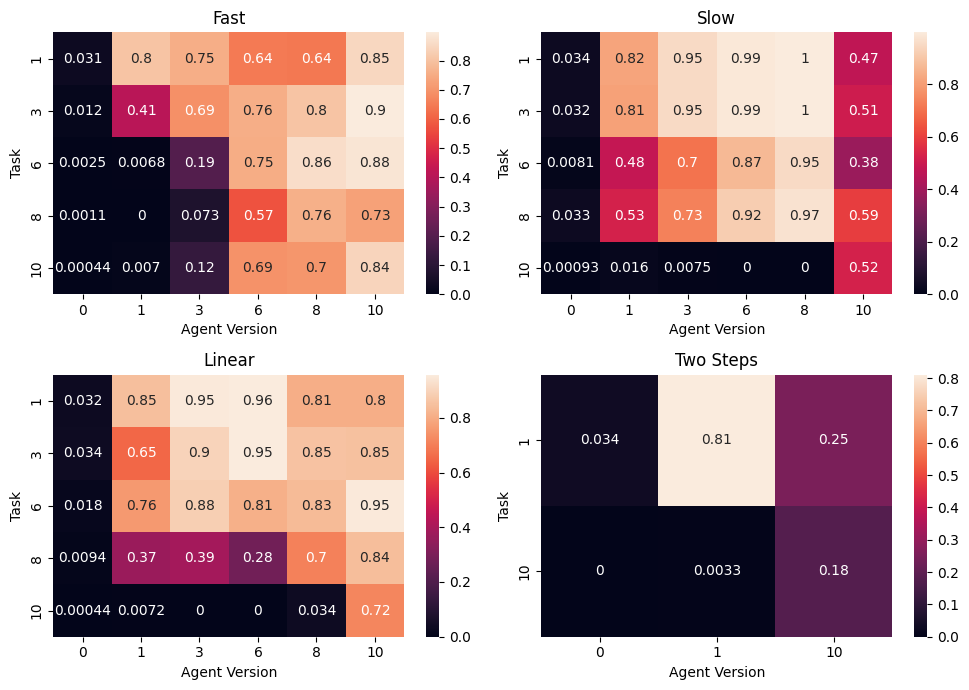

In [ ]:
trial_models = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10,7))

experiment = 'fast'

all_test_stats_df = pd.DataFrame()

for trial_model in trial_models:
  temp_df = pd.read_pickle(os.path.join(root_dir_model, experiment, str(trial_model), 'combined_test_stats_df.pkl'))
  all_test_stats_df = pd.concat([all_test_stats_df, temp_df])

test_pivot_df = all_test_stats_df[['Task', 'Agent Version', 'Episode Reward']].groupby(by=['Task', 'Agent Version']).mean().pivot_table(index='Task', columns='Agent Version', aggfunc='mean').droplevel(0, axis=1)
sns.heatmap(test_pivot_df, annot=True, ax=axs[0, 0])
axs[0, 0].set_title('Fast')

experiment = 'slow'

all_test_stats_df = pd.DataFrame()

for trial_model in trial_models:
  temp_df = pd.read_pickle(os.path.join(root_dir_model, experiment, str(trial_model), 'combined_test_stats_df.pkl'))
  all_test_stats_df = pd.concat([all_test_stats_df, temp_df])

test_pivot_df = all_test_stats_df[['Task', 'Agent Version', 'Episode Reward']].groupby(by=['Task', 'Agent Version']).mean().pivot_table(index='Task', columns='Agent Version', aggfunc='mean').droplevel(0, axis=1)
sns.heatmap(test_pivot_df, annot=True, ax=axs[0, 1])
axs[0, 1].set_title('Slow')

experiment = 'linear'

all_test_stats_df = pd.DataFrame()

for trial_model in trial_models:
  temp_df = pd.read_pickle(os.path.join(root_dir_model, experiment, str(trial_model), 'combined_test_stats_df.pkl'))
  all_test_stats_df = pd.concat([all_test_stats_df, temp_df])

test_pivot_df = all_test_stats_df[['Task', 'Agent Version', 'Episode Reward']].groupby(by=['Task', 'Agent Version']).mean().pivot_table(index='Task', columns='Agent Version', aggfunc='mean').droplevel(0, axis=1)
sns.heatmap(test_pivot_df, annot=True, ax=axs[1, 0])
axs[1, 0].set_title('Linear')

experiment = 'twosteps'

all_test_stats_df = pd.DataFrame()

for trial_model in trial_models:
  temp_df = pd.read_pickle(os.path.join(root_dir_model, experiment, str(trial_model), 'combined_test_stats_df.pkl'))
  all_test_stats_df = pd.concat([all_test_stats_df, temp_df])

test_pivot_df = all_test_stats_df[['Task', 'Agent Version', 'Episode Reward']].groupby(by=['Task', 'Agent Version']).mean().pivot_table(index='Task', columns='Agent Version', aggfunc='mean').droplevel(0, axis=1)
sns.heatmap(test_pivot_df, annot=True, ax=axs[1, 1])
axs[1, 1].set_title('Two Steps')

fig.tight_layout()
plt.show()

#### Plot trajectories of different agents

In [ ]:
# Load configs
experiment = 'fast' # Load configs from fixed_noreplay experiments
curriculum_df = pd.read_pickle(os.path.join(root_dir_model, experiment, 'curriculum_df.pkl'))
curriculum_sub_df = curriculum_df[(curriculum_df['task']==1) | (curriculum_df['task']==2) | (curriculum_df['task']==6) | (curriculum_df['task']==10)]
curriculum_sub = curriculum_sub_df.to_dict('records')

In [ ]:
# Generate videos
trial_models = 2

for config in curriculum_sub:
  agent_version = config['task']
  agent = PPOAgent(discount, lam, lr, clip_eps, num_actions, obs_size)
  agent.load_policy_model(os.path.join(root_dir_model, experiment, str(trial_models), str(agent_version)))

  env = CoBaEn(render_mode='rgb_array', config=config, minimum_plot=True)
  env = RecordVideo(env, os.path.join(root_dir_video, experiment, 'report', str(trial_models), str(agent_version)))
  env = FlattenObservation(env)
  state, info = env.reset()

  for i in range(n_teststeps):
      action = agent.act(state, True) # Non random action
      next_state, reward, terminated, truncated, info = env.step(action)
      state = next_state
 
      if terminated or truncated:   
        state, info = env.reset()

  env.close()

/usr/local/lib/python3.10/dist-packages/gym/wrappers/record_video.py:75: UserWarning: WARN: Overwriting existing videos at /content/drive/MyDrive/cobaen/videos/fast/report/2/1 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Moviepy - Building video /content/drive/MyDrive/cobaen/videos/fast/report/2/1/rl-video-episode-0.mp4.
Moviepy - Writing video /content/drive/MyDrive/cobaen/videos/fast/report/2/1/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/cobaen/videos/fast/report/2/1/rl-video-episode-0.mp4
Moviepy - Building video /content/drive/MyDrive/cobaen/videos/fast/report/2/1/rl-video-episode-1.mp4.
Moviepy - Writing video /content/drive/MyDrive/cobaen/videos/fast/report/2/1/rl-video-episode-1.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/cobaen/videos/fast/report/2/1/rl-video-episode-1.mp4
Moviepy - Building video /content/drive/MyDrive/cobaen/videos/fast/report/2/1/rl-video-episode-8.mp4.
Moviepy - Writing video /content/drive/MyDrive/cobaen/videos/fast/report/2/1/rl-video-episode-8.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/cobaen/videos/fast/report/2/1/rl-video-episode-8.mp4
Moviepy - Building video /content/drive/MyDrive/cobaen/videos/fast/report/2/1/rl-video-episode-27.mp4.
Moviepy - Writing video /content/drive/MyDrive/cobaen/videos/fast/report/2/1/rl-video-episode-27.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/cobaen/videos/fast/report/2/1/rl-video-episode-27.mp4
Moviepy - Building video /content/drive/MyDrive/cobaen/videos/fast/report/2/1/rl-video-episode-64.mp4.
Moviepy - Writing video /content/drive/MyDrive/cobaen/videos/fast/report/2/1/rl-video-episode-64.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/cobaen/videos/fast/report/2/1/rl-video-episode-64.mp4
Moviepy - Building video /content/drive/MyDrive/cobaen/videos/fast/report/2/1/rl-video-episode-125.mp4.
Moviepy - Writing video /content/drive/MyDrive/cobaen/videos/fast/report/2/1/rl-video-episode-125.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/cobaen/videos/fast/report/2/1/rl-video-episode-125.mp4
Moviepy - Building video /content/drive/MyDrive/cobaen/videos/fast/report/2/1/rl-video-episode-216.mp4.
Moviepy - Writing video /content/drive/MyDrive/cobaen/videos/fast/report/2/1/rl-video-episode-216.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/cobaen/videos/fast/report/2/1/rl-video-episode-216.mp4


/usr/local/lib/python3.10/dist-packages/gym/wrappers/record_video.py:75: UserWarning: WARN: Overwriting existing videos at /content/drive/MyDrive/cobaen/videos/fast/report/2/2 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Moviepy - Building video /content/drive/MyDrive/cobaen/videos/fast/report/2/2/rl-video-episode-0.mp4.
Moviepy - Writing video /content/drive/MyDrive/cobaen/videos/fast/report/2/2/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/cobaen/videos/fast/report/2/2/rl-video-episode-0.mp4
Moviepy - Building video /content/drive/MyDrive/cobaen/videos/fast/report/2/2/rl-video-episode-1.mp4.
Moviepy - Writing video /content/drive/MyDrive/cobaen/videos/fast/report/2/2/rl-video-episode-1.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/cobaen/videos/fast/report/2/2/rl-video-episode-1.mp4
Moviepy - Building video /content/drive/MyDrive/cobaen/videos/fast/report/2/2/rl-video-episode-8.mp4.
Moviepy - Writing video /content/drive/MyDrive/cobaen/videos/fast/report/2/2/rl-video-episode-8.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/cobaen/videos/fast/report/2/2/rl-video-episode-8.mp4
Moviepy - Building video /content/drive/MyDrive/cobaen/videos/fast/report/2/2/rl-video-episode-27.mp4.
Moviepy - Writing video /content/drive/MyDrive/cobaen/videos/fast/report/2/2/rl-video-episode-27.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/cobaen/videos/fast/report/2/2/rl-video-episode-27.mp4
Moviepy - Building video /content/drive/MyDrive/cobaen/videos/fast/report/2/2/rl-video-episode-64.mp4.
Moviepy - Writing video /content/drive/MyDrive/cobaen/videos/fast/report/2/2/rl-video-episode-64.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/cobaen/videos/fast/report/2/2/rl-video-episode-64.mp4
Moviepy - Building video /content/drive/MyDrive/cobaen/videos/fast/report/2/2/rl-video-episode-125.mp4.
Moviepy - Writing video /content/drive/MyDrive/cobaen/videos/fast/report/2/2/rl-video-episode-125.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/cobaen/videos/fast/report/2/2/rl-video-episode-125.mp4


/usr/local/lib/python3.10/dist-packages/gym/wrappers/record_video.py:75: UserWarning: WARN: Overwriting existing videos at /content/drive/MyDrive/cobaen/videos/fast/report/2/6 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Moviepy - Building video /content/drive/MyDrive/cobaen/videos/fast/report/2/6/rl-video-episode-0.mp4.
Moviepy - Writing video /content/drive/MyDrive/cobaen/videos/fast/report/2/6/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/cobaen/videos/fast/report/2/6/rl-video-episode-0.mp4
Moviepy - Building video /content/drive/MyDrive/cobaen/videos/fast/report/2/6/rl-video-episode-1.mp4.
Moviepy - Writing video /content/drive/MyDrive/cobaen/videos/fast/report/2/6/rl-video-episode-1.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/cobaen/videos/fast/report/2/6/rl-video-episode-1.mp4
Moviepy - Building video /content/drive/MyDrive/cobaen/videos/fast/report/2/6/rl-video-episode-8.mp4.
Moviepy - Writing video /content/drive/MyDrive/cobaen/videos/fast/report/2/6/rl-video-episode-8.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/cobaen/videos/fast/report/2/6/rl-video-episode-8.mp4
Moviepy - Building video /content/drive/MyDrive/cobaen/videos/fast/report/2/6/rl-video-episode-27.mp4.
Moviepy - Writing video /content/drive/MyDrive/cobaen/videos/fast/report/2/6/rl-video-episode-27.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/cobaen/videos/fast/report/2/6/rl-video-episode-27.mp4
Moviepy - Building video /content/drive/MyDrive/cobaen/videos/fast/report/2/6/rl-video-episode-64.mp4.
Moviepy - Writing video /content/drive/MyDrive/cobaen/videos/fast/report/2/6/rl-video-episode-64.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/cobaen/videos/fast/report/2/6/rl-video-episode-64.mp4
Moviepy - Building video /content/drive/MyDrive/cobaen/videos/fast/report/2/6/rl-video-episode-125.mp4.
Moviepy - Writing video /content/drive/MyDrive/cobaen/videos/fast/report/2/6/rl-video-episode-125.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/cobaen/videos/fast/report/2/6/rl-video-episode-125.mp4


/usr/local/lib/python3.10/dist-packages/gym/wrappers/record_video.py:75: UserWarning: WARN: Overwriting existing videos at /content/drive/MyDrive/cobaen/videos/fast/report/2/10 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Moviepy - Building video /content/drive/MyDrive/cobaen/videos/fast/report/2/10/rl-video-episode-0.mp4.
Moviepy - Writing video /content/drive/MyDrive/cobaen/videos/fast/report/2/10/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/cobaen/videos/fast/report/2/10/rl-video-episode-0.mp4
Moviepy - Building video /content/drive/MyDrive/cobaen/videos/fast/report/2/10/rl-video-episode-1.mp4.
Moviepy - Writing video /content/drive/MyDrive/cobaen/videos/fast/report/2/10/rl-video-episode-1.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/cobaen/videos/fast/report/2/10/rl-video-episode-1.mp4
Moviepy - Building video /content/drive/MyDrive/cobaen/videos/fast/report/2/10/rl-video-episode-8.mp4.
Moviepy - Writing video /content/drive/MyDrive/cobaen/videos/fast/report/2/10/rl-video-episode-8.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/cobaen/videos/fast/report/2/10/rl-video-episode-8.mp4
Moviepy - Building video /content/drive/MyDrive/cobaen/videos/fast/report/2/10/rl-video-episode-27.mp4.
Moviepy - Writing video /content/drive/MyDrive/cobaen/videos/fast/report/2/10/rl-video-episode-27.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/cobaen/videos/fast/report/2/10/rl-video-episode-27.mp4
Moviepy - Building video /content/drive/MyDrive/cobaen/videos/fast/report/2/10/rl-video-episode-64.mp4.
Moviepy - Writing video /content/drive/MyDrive/cobaen/videos/fast/report/2/10/rl-video-episode-64.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/cobaen/videos/fast/report/2/10/rl-video-episode-64.mp4


In [ ]:
# Load example videos and extract last frame
files = [{'trial': 1, 'agent_version': 1, 'file_name': 'rl-video-episode-64.mp4'}, # Task 1
         {'trial': 1, 'agent_version': 2, 'file_name': 'rl-video-episode-64.mp4'}, # Task 2
         {'trial': 1, 'agent_version': 6, 'file_name': 'rl-video-episode-1.mp4'}, # Task 6
         {'trial': 2, 'agent_version': 10, 'file_name': 'rl-video-episode-0.mp4'}] # Task 10

In [ ]:
for file in files:

  trial = file['trial']
  agent_version = file['agent_version']
  file_name = file['file_name']

  # Load video
  path = os.path.join(root_dir_video, experiment, 'report', str(trial), str(agent_version), file_name)

  vidcap = cv2.VideoCapture(path)
  success, image = vidcap.read()
  count = 1

  while success:
    cv2.imwrite(os.path.join(root_dir_video, experiment, 'report', str(trial), str(agent_version), f'frame.jpg'), image) # just overwrite image
    success, image = vidcap.read()
    count += 1

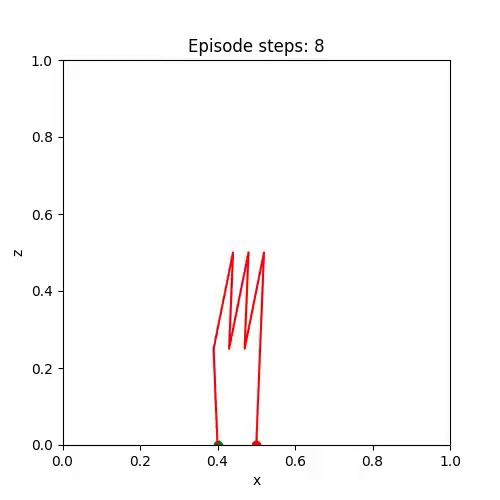

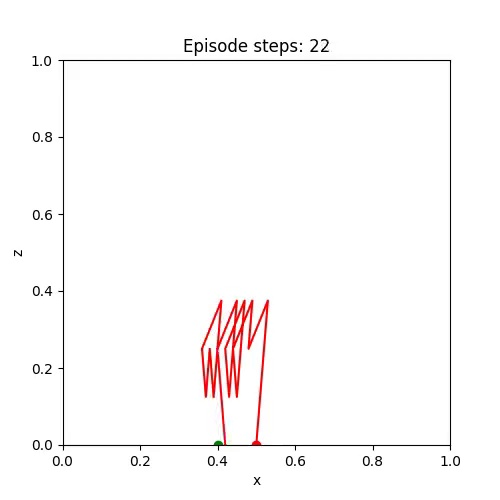

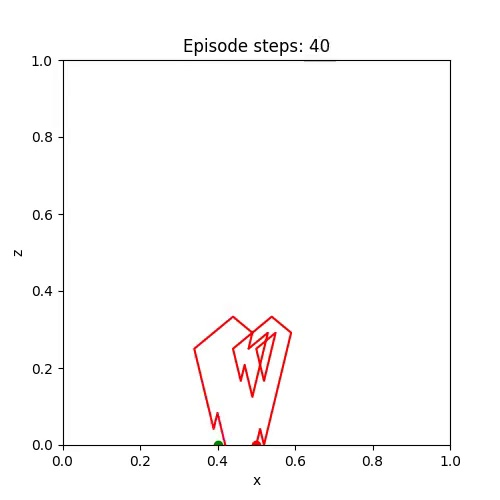

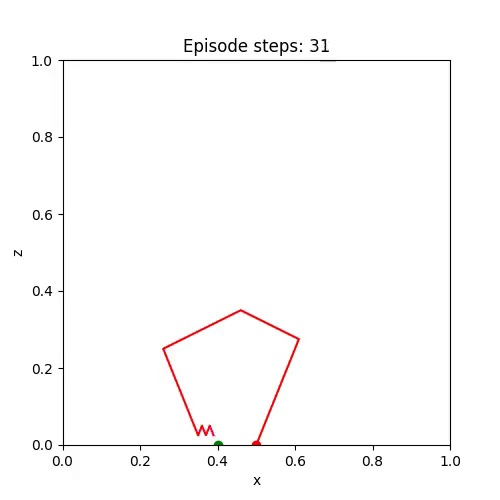

In [ ]:
from google.colab.patches import cv2_imshow

# Display images for each agent version 
for file in files:

  trial = file['trial']
  agent_version = file['agent_version']
  image = cv2.imread(os.path.join(root_dir_video, experiment, 'report', str(trial), str(agent_version), f'frame.jpg'))
  cv2_imshow(image)

#### Experiment Overview Average Number of Total Steps, Average Number of Tasks in Curriculum, Average Test Reward

In [ ]:
trials = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
fixed_experiments = ['fast', 'linear', 'slow', 'twosteps']

In [ ]:
# Fixed Curriculum average number of training steps
number_training_steps = []

for experiment in fixed_experiments:

  trial_total_steps = 0

  for trial in trials:
    stats_df = pd.read_pickle(os.path.join(root_dir_model, experiment, str(trial), 'train_stats_df.pkl'))

    # Add total steps per Trial
    trial_total_steps += stats_df['Total Steps'].max()

  avg_total_steps = trial_total_steps / len(trials)

  number_training_steps.append({
      'experiment': experiment,
      'avg_training_steps': avg_total_steps
  })

In [ ]:
# Adaptive Curriculum average number of training steps
experiment = 'adaptive'
trial_total_steps = 0

for trial in trials:

  # Read number of sample iteration in specific trial
  all_samples_stats_df = pd.read_pickle(os.path.join(root_dir_model, experiment, str(trial), f'all_samples_stats_df.pkl'))

  # Get number of training steps per iteration/task
  for task in range(1, all_samples_stats_df['Sample Iteration'].max()+1):
    train_stats_df = pd.read_pickle(os.path.join(root_dir_model, experiment, str(trial), f'train_stats_df_{task}.pkl'))

    # Add total steps per Task
    trial_total_steps += train_stats_df['Total Steps'].max()

avg_total_steps = trial_total_steps / len(trials)

number_training_steps.append({
    'experiment': experiment,
    'avg_training_steps': avg_total_steps
})

In [ ]:
df_number_training_steps = pd.DataFrame(number_training_steps).set_index('experiment')
df_number_training_steps

,avg_training_steps
experiment,
fast,142274.4
linear,197475.6
slow,128851.9
twosteps,119039.3
adaptive,177922.9


In [ ]:
number_of_tasks = [{'experiment': 'fast',
                    'number_of_tasks': 10},
                   {'experiment': 'linear',
                    'number_of_tasks': 10},
                   {'experiment': 'slow',
                    'number_of_tasks': 10},
                   {'experiment': 'twosteps',
                    'number_of_tasks': 2}
                   ]

# Average number of tasks in adaptive curriculum
tasks = 0

for trial in trials:

  # Read number of sample iteration in specific trial
  all_samples_stats_df = pd.read_pickle(os.path.join(root_dir_model, experiment, str(trial), f'all_samples_stats_df.pkl'))

  # Number of tasks
  tasks += all_samples_stats_df['Sample Iteration'].max()

number_of_tasks.append({'experiment': experiment, 'number_of_tasks': tasks / len(trials)})

df_number_of_tasks = pd.DataFrame(number_of_tasks).set_index('experiment')
df_number_of_tasks

,number_of_tasks
experiment,
fast,10.0
linear,10.0
slow,10.0
twosteps,2.0
adaptive,4.4


In [ ]:
# Fixed Curriculum average test reward results
# Same test results as in task/agent combination test (for final task 10 and agent version 10)
avg_test_reward = []

for experiment in fixed_experiments:
  all_test_stats_df = pd.DataFrame()

  for trial in trials:
    temp_df = pd.read_pickle(os.path.join(root_dir_model, experiment, str(trial), 'combined_test_stats_df.pkl'))
    all_test_stats_df = pd.concat([all_test_stats_df, temp_df])
    final_test_filter = (all_test_stats_df['Task']==10) & (all_test_stats_df['Agent Version']==10)
    filtered_df = all_test_stats_df[final_test_filter]
  
  test_reward = filtered_df['Episode Reward'].mean()

  avg_test_reward.append({
      'experiment': experiment,
      'avg_test_reward': test_reward
  })

In [ ]:
# Adaptive Curriculum average reward on final task with last sample iteration
experiment = 'adaptive'

final_rewards = []

for trial in trials:
  all_samples_stats_df = pd.read_pickle(os.path.join(root_dir_model, experiment, str(trial), f'all_samples_stats_df.pkl'))
  final_reward = all_samples_stats_df.iloc[-1]['Reward Final']
  final_rewards.append(final_reward)

test_reward = np.round(np.mean(final_rewards), 2)

avg_test_reward.append({
      'experiment': experiment,
      'avg_test_reward': test_reward
  })

In [ ]:
df_test_reward = pd.DataFrame(avg_test_reward).set_index('experiment')
df_test_reward

,avg_test_reward
experiment,
fast,0.842920
linear,0.715232
slow,0.524709
twosteps,0.179856
adaptive,0.750000


In [ ]:
# Merge all results (number of steps, number tasks, test reward)
df_number_training_steps.join([df_number_of_tasks, df_test_reward])

,avg_training_steps,number_of_tasks,avg_test_reward
experiment,,,
fast,142274.4,10.0,0.842920
linear,197475.6,10.0,0.715232
slow,128851.9,10.0,0.524709
twosteps,119039.3,2.0,0.179856
adaptive,177922.9,4.4,0.750000
